# Stochastic 3
#### Agent-Based Bacteriophage Simulation
Aaron Smith 2024.  
Design Informed by Michael Hunter 2022/23. 

## Introduction

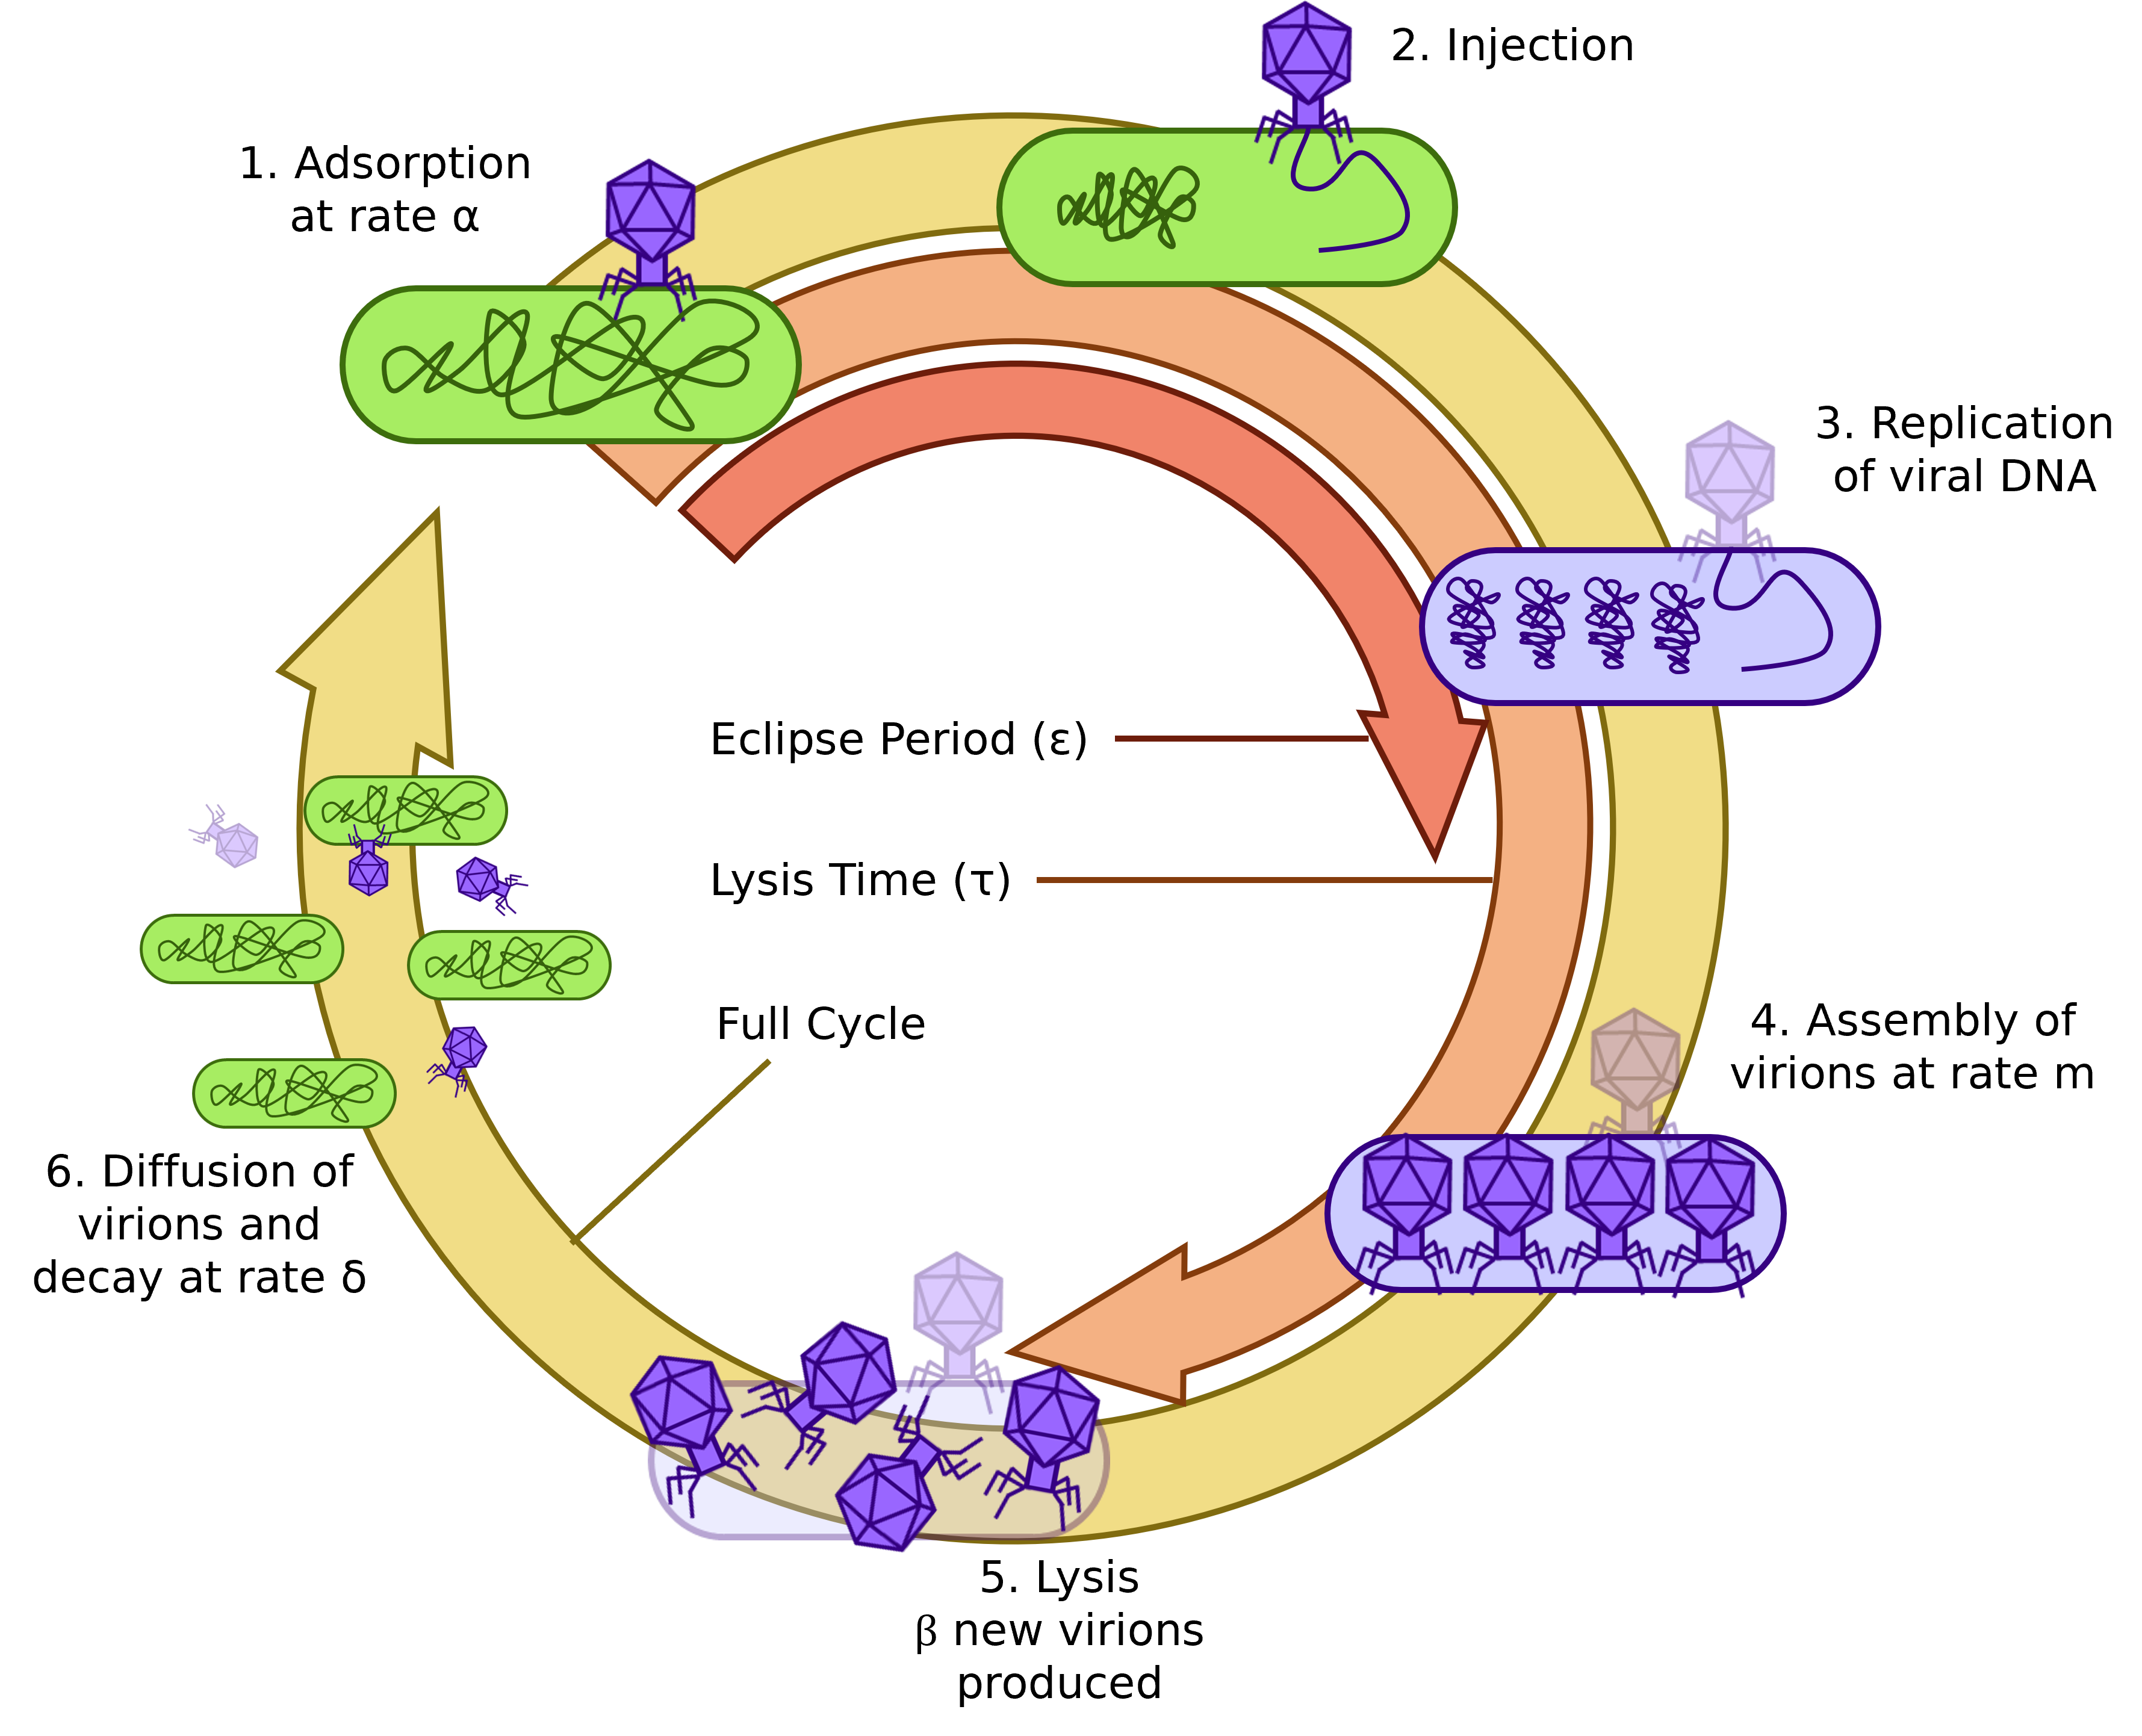

#### Contents:
To Do
    
#### Versions:
**Stochastic 2.0 (April 2023)** - Design similar to Michael's code, except dictionaries employed to allow adding additional tau, beta and growth functions later on. Can also cope with any number of bacterial and phage species.  
**Stochastic 2.1 (April 2023)** - Redesigned 'Infect' function so bacteria now save a list of phages attempting infection and then select a "winner". This is to be future-compatable with Stearic Limit and Restriction Enzyme functions. Steric and Receptor limit parameters introduced. Script now terminates when one phage's population (after bottleneck) reaches a predetermined proportion of the total. Now plots healthy and infected cells of each type.  
**Stochastic 2.2 (May 2023)** - Decay function now poisson rather than determinsitc, implemented clip to Choua Function to ensure burst is always non-negative, even at large eclipse periods; code now returns the time at which the simulation breaks.  
**Stochastic 2.3 (June 2023)** - Changed behaviour so that, when the script is called from commandline, Tau_Mean_2 and Tau_STD_2 are automatically generated based on slurm array index.  
**Stochastic 2.4 (August 2023)** - Added 'Exponential', 'Log Normal', and **(2.4.1)** 'Skew Normal' Tau Distributions.  
**Stochastic 2.5 (September 2023)** - Added 'Scramble_Lysis_Cycles' function, allows sim to begin desynchronised.  
**Stochastic 2.6 (March 2024)** - Added 'Harmonic Normal' Tau Distribution.  
**Stochastic 3.0 (May 2024)** - Extensive redesign. Can now select an experiment at initialisation, including 1 dimesnional plaque growth across bacterial lawn. Code reworked to run with spatial 'Demes', and now also returns empirical growth rates for each phage species. Additionally, each deme now includes a single set of all bacteria, rather than a set of sets.  
**Stochastic 3.1 (September 2024)** - Added 'Treadmill' experiment, reworked analysis functions.  
**Stochastic 3.2 (September 2024)** - Added 'Death_Curve_1v1' experiment. Script now returns full dataset at the end, one file per rep, as well as "headline results" together in a single file.  
**Stochastic 3.3 (December 2024)** - Revised calculation of delta F, to work in one dimension and give more consistent results in zero dimensions. (Now based on ratio of infected cells, rather than phages). **(3.3.1)** Delta F is now calculated in two different ways for Serial Passage experiments, and an additional "zeroth" bottleneck event has been added so line fitting should never fail. **(3.3.2)** Fixed a few bugs in calculation of Delta F which caused the code to fail when one phage population went to zero immediately, or was initialised at zero. **(3.3.3)** Fixed an additional bug which caused the code to fail in Treadmill mode when one phage had been eliminated before the onset of travelling wave behaviour.  
**Stochastic 3.4 (April 2025)** - Revised prediction function to draw adsorption time from an exponential distribution.  
**Stochastic 3.5 (May 2025)** - Added 'Variable Passage' experiment: a serial-passage but with alternating dilution factors.  
**Stochastic 3.6 (June 2025)** Added Weibull and Erlang distributions.

#### Set Comprehension


version 3.1 now uses lsit comprehension with generator expressions:  
```
[operation for item in list]  
[operation for item in list if logical]
```  

e.g.  
```
print([obj.strain for obj in demes[1]])
print([obj.strain for obj in demes[1] if type(obj) == Bacteria])
```

previously used sets (replace ```[]``` with ```{}```) which have unique entries BUT have non-determinisitc ordering

## 0. Read This First

This notebook simulates lysis of a number of susceptible bacterial populations by multiple competing populations of bacteriophage virus. The simulation is stochastic and agent-based, and has written to be as "future-proof" as possible. I.e. cells call appropriate functions, rather than if/then statements, such that functions may be added or modified at a later time.

#### High Level Overview:
At the beginning of the simulation the user specifies an experiment (e.g. Serial Passage, Lysis Curve, or Plaque Expansion, along with parameters for the bacteria and phage present. A set of spatial Demes are created, each populated with a set of 'Bacteria' objects, along with a single 'Bacteriophage_Population' object for each species of infecting phage. Each 'Bacteria' object individually tracks how long it has left before duplication, or before lysis. There is no reference to any absolute time.  

At every timestep, the following happen:
- Bacteria Grow (according to specified function)
- Phage adsorb (according to specified function)
- Newly infected bacteria:
    - Choose a phage type (if infection is attempted by more than one phage species).
    - Determine a lysis time from distribution of tau.
- Currently infected bacteria check whether to lyse.
    - If so, produce new phage according to the system's burst function.
- Phage decay.
- Phage diffuse to adjacent demes
- Populations are recorded.

We seek to capture the behaviour of the model
$$ B  \stackrel{T}{\rightarrow} 2B $$
$$ B + V \stackrel{\alpha}{\rightarrow} I \stackrel{\tau}{\rightarrow} \beta V$$
$$ V  \stackrel{\delta}{\rightarrow} 0 $$
In which:  
$T$ denotes the doubling *time*. (Time to double is drawn from a distribution with mean $T$).  
$\alpha$ denotes the adsorbtion *rate*. (The number of adsorbtions has mean $\frac{\alpha(B+I)V\Delta t}{Vol}$), where $Vol$ is the volume being simulated 
$\tau$ denotes the lysis *time*. (Time to lysis is drawn from a distribution with mean $\tau$).  
$\beta$ denotes the burst size. (Burst is drawn either from a distribution with mean $\beta$, OR $\beta$ is calculated deterministically from some function $\beta(\tau)$).  
$\delta$ denotes the decay *rate*. (Number of phage to decay is drawn from a distribution with mean $\delta V \Delta t$).

#### Case Convention:
Rather than abstract variables, we use the full names wherever possible. For example functions are defined in terms of 'burst_size' rather than b.  
Custom functions and classes are always Captialised.  
Everything else is lower case.

## 1. Import Statements and Colours

In [1]:
## Import Statements
import math
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import itertools as itl
import sys
import copy
from numba import jit

# We no longer use animatplot
# We no longer use AliveBar.

## Colours
green = "#6dc317"
yellow = "#e8c636"
orange = "#ed7d31"
red = "#d93a15"
purple = "#8c43ed"
blue = "#177add"
black = "#000000"
charcoal = "#2f2f2f"
grey = "#c2c2c2"
white = "#ffffff"
off_white = "#fafafa"

all_colours = [green, yellow, orange, red, purple, blue, charcoal, grey, off_white]
bacteria_colours = [yellow, green, orange]
bacteriophage_colours = [red, purple, blue]

## 2. Argument Interpretation

This section allows the script to be called wth an argument from command line, e.g.  
```
Stochastic_3.py 66
```
calls the script with arugment "66".  

For this to be useful, ~2~ (now 3!) arrays of external values (EVAs) must be supplied below.

In [2]:
## External Value Arrays

eva1 = np.linspace(10, 40, 31)  # means
eva2 = np.linspace(2.5*10/17, 2.5*40/17, 31)  # stds
eva3 = np.linspace(1, 20, 20)  # seeds

print(eva1)
print(eva2)
print(eva3)

[10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.]
[1.47058824 1.61764706 1.76470588 1.91176471 2.05882353 2.20588235
 2.35294118 2.5        2.64705882 2.79411765 2.94117647 3.08823529
 3.23529412 3.38235294 3.52941176 3.67647059 3.82352941 3.97058824
 4.11764706 4.26470588 4.41176471 4.55882353 4.70588235 4.85294118
 5.         5.14705882 5.29411765 5.44117647 5.58823529 5.73529412
 5.88235294]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


In [3]:
## External Argument Interpretation

try:
    ext_arg = int(sys.argv[1])
except:
    ext_arg = None
else:
    ext_arg = int(sys.argv[1])
    
print("ext_arg:",ext_arg)

ext_arg: None


In [4]:
## Select Value from EVAs

if ext_arg != None:
    base = len(eva2)*len(eva3)
    hundreds = int(ext_arg // base)
    remainder = int(ext_arg % base)

    base = len(eva3)
    tens = int(remainder // base)
    units = int(remainder % base)

    ext_val_1 = eva1[hundreds]
    ext_val_2 = eva2[tens]
    ext_val_3 = eva3[units]
    
    print("ext_val_1:",ext_val_1)
    print("ext_val_2:",ext_val_2)
    print("ext_val_3:",ext_val_3)
    

## 3. Define Tau Distributions:

This section defines the distributions that can be called by cells to determine either a time-to-doubling, or time-to-lysis. All functions are lower bounded, and for inter-operability, all take the same arugments:
```
Distribution(mean, std, lower_bound, alpha)
```

#### Delta Function
This "distribution" will always return the mean.

In [5]:
@jit(nopython=True)
def Delta_Function(mean, std = 0, lower_bound = 0, alpha = None):
    return(mean)

#### Normal / Gaussian Distribution

$$P_N(x) = \frac{1}{\sqrt{2\sigma^2\pi}}e^{\frac{-(x-\mu)^2}{2\sigma^2}}$$

In [6]:
@jit(nopython=True)
def Normal(mean, std, lower_bound = 0, alpha = None):
    x = -1
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = np.random.normal(loc = mean, scale = std)
        return(x)

# Draws a random number from a Gaussian / Normal distribution.
# If that number is less than the specified lower bound, draws again (ad infinitum).
# Note: lower_bound must be greater than or equal to zero.

#### Gamma Distribution

$$P_\gamma(x) = \frac{x^{k-1}e^{-x/\theta}}{\theta^k \Gamma(k)}$$

Where $\Gamma(k)$ is the Gamma Function, equivalent to $k!$ for positive integer $k$.  
The Gamma distribution has mean $\mu = k\theta$, and variance $\sigma^2 = k\theta^2$.  
We specify the mean and std, which are converted to a shape and scale.

In [7]:
# @jit implementation not supported
def Gamma(mean, std, lower_bound = 0, alpha = None):
    x = -1
    k = mean**2 / std**2
    theta = std**2 / mean
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = np.random.gamma(shape = k, scale = theta)
        return(x)

# Draws a random number from a Gamma distribution.
# If that number is less than the specified lower bound, draws again (ad infinitum).
# Note: lower_bound must be greater than or equal to zero.

#### Exponential Distribution:

Density: $p(x) = Ae^{-kx}$ for $L<x<\infty$  
Normalisation: $A = ke^{kL}$  
Cumulative: $P(x) = 1 - e^{k(L-x)}$  
Inverse Cumulative: $x = L - \frac{ln(1-P)}{k}$  
Mean: $\langle x \rangle = L + \frac{1}{k}$  
Obtain Rate from Mean: $k = \frac{1}{\langle x\rangle - L}$

In [8]:
@jit(nopython=True)
def Exponential(mean, std = None, lower_bound = 1, alpha = None):
    
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    
    rate = 1/(mean - lower_bound)
    
    x = -1
    P = np.random.rand()
    while x < lower_bound:
        x = lower_bound - (np.log(1-P)/rate)
    return(x)

# Draws a random number from an exponential distribution.
# If that number is less than the specified lower bound, draws again (ad infinitum).
# Note - This distribution is specified by the Mean and LB ONLY.

#### Log Normal Distribution

Probability is normal in ln($\tau$).  
For this function, mean, std, and lower_bound are taken to refer to the function ***in log space***.  

For example:
```
Log_Normal(4, 1)
```

Will return a distribution with mean $e^4$ and 67% of values between $e^3$ and $e^5$

In [9]:
@jit(nopython=True)
def Log_Normal(mean, std, lower_bound = 0, alpha = None):
    x = Normal(mean, std, lower_bound)
    y = np.exp(x)
    return(y)

#### Skew Normal Distribution

Generalisation of the Normal Distribution to allow non-zero skew.  
PDF given by

$$P(x, \mu, \sigma, a) = \frac{2}{\sigma}p_N\bigl(\frac{x - \mu}{\sigma}\bigr) \times c_N\bigl(a\frac{x - \mu}{\sigma}\bigr)$$

in which: $p_N$ is the Normal Distribution PDF for variable $x$, (or $\frac{x - \mu}{\sigma}$), and $c_N$ is the Normal Distribution CDF.  
Note that $a$, which can range from $-\infty$ to $+\infty$ is *not* the Skew, which ranges -1 to 1.  


This is made worse by the fact that the true sample mean and std do not match the nominal mean and std. If true mean is $M$ and true std is $\Sigma$, and we define $\delta = \frac{\alpha}{\sqrt{1 + \alpha^2}}$then:

$$M = \mu + \sigma\delta\sqrt{\frac{2}{\pi}}$$

$$\Sigma^2 = \sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)$$

Inverting these to generate $\mu$, $\sigma$ from supplied true mean and std:

$$\sigma^2 = \Sigma^2 \bigl( 1 - \frac{2\delta^2}{\pi} \bigr)^{-1}$$

$$\mu = M - \sigma\delta\sqrt{\frac{2}{\pi}}$$

In [10]:
# @jit implementation not supported - To Do, rewrite in terms of compilable numpy distributions
def Skew_Normal(mean, std, lower_bound = 0, alpha = 0):
    
    delta = alpha / (1 + alpha**2)**(0.5)
    sigma = (std**2 * (1 - (2*delta**2)/(np.pi))**(-1))**(0.5)
    mu = mean - sigma*delta*(2/np.pi)**(0.5)
    
    x = -1
    if lower_bound < 0:
        raise Exception("lower_bound must be greater than or equal to zero")
        return(0)
    else: 
        while x < lower_bound:
            x = sp.stats.skewnorm.rvs(size = 1, loc = mu, scale = sigma, a = alpha)[0]
        return(x)
    

#### Reciprocal / Harmonic Normal Distribution

Probability is normal in $1/\tau$.  
For this function mean and std, are taken to refer to the function ***in reciprocal space***.  
lower_bound is applied ***in real space***.

In [11]:
@jit(nopython=True)
def Reciprocal_Normal(mean, std, lower_bound = 0.001, alpha = None):
    if lower_bound < 0.001:
        raise Exception("lower_bound must be greater than or equal to 0.001")
        return(0)
    
    else:
        y = -1
        while y < lower_bound:
            x = Normal(mean, std, lower_bound)    # perimitting a maximum tau of 1000 minutes.
            y = 1.0/x
    return(y)


#### Weibull Disitribution
$$p(x,k,\lambda) = \frac{k}{\lambda}\frac{x^{k-1}}{\lambda}e^{-(x/\lambda)^k}$$
for $$x, k, \lambda > 0$$

The distribution has ```shape``` (k) and ```scale``` $(\lambda)$ arguments in numpy.

Empirically, $$k \approx 1/CV = \frac{\overline{x}}{\Delta x}$$
So, $$\lambda \approx \frac{\overline{x}}{\Gamma(1 + 1/k)}$$

In [12]:
def Weibull(mean, std, lower_bound, alpha):
    shape = mean/std
    scale = mean/(math.gamma(1 + 1/shape))
    return(scale*np.random.weibull(shape))

#### Weibull_2
Altneratively, we can call the Weibull using ```scale``` and ```shape``` directly:

In [13]:
def Weibull_2(scale, shape, lower_bound, alpha):
    return(scale*np.random.weibull(shape))

#### Erlang Distribution
The Erlang distribution arises from multiple coupled exponential processes.
$$p(x,k,\lambda) = \frac{\lambda^k x^{k-1}e^{-\lambda x}}{(k-1)!}$$

For shape $k$ and rate $\lambda$. It has mean $k/\lambda$ and std $\sqrt{k}/\lambda$.

Therefore:
$$\lambda = \frac{\overline{x}}{\Delta x^2}$$
$$k = \frac{\overline{x}^2}{\Delta x^2} = \lambda\overline{x}$$

Scipy uses the parameters ```a``` and ```scale```. ```a``` is equivalent to $k$ and ```scale``` is equivalent to $1/\lambda$.

In [14]:
def Erlang(mean, std, lower_bound, alpha):
    scale = std**2 / mean
    shape = mean**2 / std**2
    return(sp.stats.erlang.rvs(scale = scale, a = shape))

#### Erlang_2
Alternatively, we can define the Erlang with scale and shape directly.

In [15]:
def Erlang_2(scale, shape, lower_bound, alpha):
    return(sp.stats.erlang.rvs(scale = scale, a = shape))

#### Plot Distributions

To better visualise the different distributions avaialbe, we plot them all here for comparable mean and std.

In [16]:
## Plot Distributions
plot = False

if plot:
    # Set Parameters
    sample_size = 256_000
    number_of_bins = 256
    global_min = 0
    global_max = 40
    
    # Define Distributions
    dist = [Normal, Gamma, Exponential, Log_Normal, Skew_Normal, Reciprocal_Normal, Weibull, Erlang]
    mean = [17, 17, 17, np.log(17), 17, 1.0/17, 17, 17]
    std = [2.5, 2.5, None, 0.07, 2.5, 0.3/17, 2.5, 2.5]
    lower_bound = [0.01, 0.01, 14.5, 0.01, 0.01, 0.01, None, None]
    alpha = [None, None, None, None, 6, None, None, None]
    
    # Calculate Parameters
    bin_width = (global_max - global_min) / number_of_bins
    rescale = 1 / (bin_width*sample_size)
    
    # Generate Samples
    fig, ax = plt.subplots(1, 1)
    
    for i in range(0, len(dist)):    # For every distribution we have defined
        sample = np.zeros(sample_size)             # Create an array of zeros
        function_to_call = dist[i]                 # Import the function
        function_as_string = dist[i].__name__      # And the corresponding string
        
        for j in range(0, sample_size):
            sample[j] = function_to_call(mean[i], std[i], lower_bound[i], alpha[i])      # Draw samples
        
        print("Distribution {} of {}: {}".format(i+1, len(dist), dist[i]))
        print("Mean:", np.mean(sample))
        print("STD:", np.std(sample))
        print("Skew:", sp.stats.skew(sample))
        
        counts, bins = np.histogram(sample, bins = number_of_bins, range = (global_min, global_max))    # Then plot a histogram
        bin_centers = bins[1:]
        bin_gap = bins[1] - bins[0]
        for k in range(len(bin_centers)):
            bin_centers[k] -= bin_gap
        
    
        ax.plot(bin_centers, counts, label = function_as_string, color = all_colours[i])
    
        
    # Format Graph
    ax.legend(loc = "best")
    ax.set_title("Tau Distributions")
    
    plt.show()
    plt.clf()

In [17]:
## Plot More Distributions
plot = False

if plot:
    # Set Parameters
    sample_size = 256_000
    number_of_bins = 256
    global_min = 0
    global_max = 40
    
    # Define Distributions
    dist = [Normal, Weibull_2, Weibull_2, Weibull_2, Weibull_2, Weibull_2, Weibull_2, Weibull_2]
    mean = [17, 17, 17, 17, 17, 17, 17, 17]  # scale
    std = [2.5, 1, 1.5, 2, 3, 5, 10, 15]  # shape
    lower_bound = [0.01, None, None, None, None, None, None, None]
    alpha = [None, None, None, None, None, None, None, None]
    
    # Calculate Parameters
    bin_width = (global_max - global_min) / number_of_bins
    rescale = 1 / (bin_width*sample_size)
    
    # Generate Samples
    fig, ax = plt.subplots(1, 1)
    
    for i in range(0, len(dist)):    # For every distribution we have defined
        sample = np.zeros(sample_size)             # Create an array of zeros
        function_to_call = dist[i]                 # Import the function
        function_as_string = dist[i].__name__      # And the corresponding string
        
        for j in range(0, sample_size):
            sample[j] = function_to_call(mean[i], std[i], lower_bound[i], alpha[i])      # Draw samples
        
        print("Distribution {} of {}: {}".format(i+1, len(dist), dist[i]))
        print("Mean:", np.mean(sample))
        print("STD:", np.std(sample))
        print("Skew:", sp.stats.skew(sample))
        
        counts, bins = np.histogram(sample, bins = number_of_bins, range = (global_min, global_max))    # Then plot a histogram
        bin_centers = bins[1:]
        bin_gap = bins[1] - bins[0]
        for k in range(len(bin_centers)):
            bin_centers[k] -= bin_gap
        
    
        ax.plot(bin_centers, counts, label = function_as_string, color = all_colours[i])
    
        
    # Format Graph
    ax.legend(loc = "best")
    ax.set_title("Tau Distributions")
    
    plt.show()
    plt.clf()

## 4. Define Burst Functions

Simulation can be run using any of four depenedencies of burst size on lysis time:

$\beta_1 = \beta$

$\beta_2 = m\tau$

$\beta_3 = m(\tau - \epsilon)$

$\beta_4 = N(\overline{\beta}, \Delta\beta, \beta_{min})$

For interoperability, all functions take all arguments:
```
Beta(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound)
```

In [18]:
## Functions

@jit(nopython=True)
def Beta_Constant(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound):
    return(round(beta_mean))

@jit(nopython=True)
def Beta_Linear(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound):
    return(round(tau * maturation_rate))

def Beta_Choua(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound):
    return(np.clip(round((tau - eclipse_period) * maturation_rate), a_min = 0, a_max = None))

@jit(nopython=True)
def Beta_Normal(tau, maturation_rate, eclipse_period, beta_mean, beta_std, beta_lower_bound):
    return (round(Normal(beta_mean, beta_std, beta_lower_bound)))

## 5. The 'Bacteria' Class

In [19]:
class Bacteria:
    def __init__(self, strain,
                 growth_function, doubling_time_mean, doubling_time_std, doubling_time_lower_bound, doubling_time_alpha,
                 maximum_adsorbed):
        
        # Type Properties
        self.strain = strain    # numerical species identifier
        self.infected = 0       # 0 if healthy, "1" if infected with phage strain "1" etc
        self.newly_infected = 0    # as .infected, but reset to 0 after the first timestep (used to track infection rate and aggregate)
        self.invaders = []      # list of phages currently attempting to invade the cell. [1,1,3] means 2 from type 1 and 1 from type 3.
        
        # Growth Properties
        self.growth_function = growth_function
        self.doubling_time_mean = doubling_time_mean
        self.doubling_time_std = doubling_time_std
        self.doubling_time_lower_bound = doubling_time_lower_bound
        self.doubling_time_alpha = doubling_time_alpha
        
        # Infection / Defense Properties
        self.maximum_adsorbed = maximum_adsorbed
        self.burst_size = None    # Will be calculated at moment of infection
        
        # Countdowns - time to mitosis calculated at creation, time to lysis calculated on infection (countdown then ticks down, total does not).
        self.countdown_mitosis = growth_function(doubling_time_mean, doubling_time_std, doubling_time_lower_bound)
        self.total_mitosis = self.countdown_mitosis
        self.countdown_lysis = -1
        self.total_lysis = -1
        
    def __repr__(self):    # representation for printing / interactive prompt
        return("Bac{}.{}".format(self.strain, self.infected))

## Currently it is assumed that bacteria do not diffuse / migrate between demes.

## 6. The 'Bacteriophage_Population' Class

In [20]:
class Bacteriophage_Population:
    def __init__(self, strain, initial_size,
                 adsorption_rate,
                 decay_rate, diffusion_rate,
                 eclipse_period, maturation_rate,
                 burst_function, burst_size_mean, burst_size_std, burst_size_lower_bound,
                 tau_distribution, lysis_time_mean, lysis_time_std, lysis_time_lower_bound, lysis_time_alpha):
        
        # Population Properties
        self.strain = strain
        self.size = initial_size
        
        # Adsorption Properties
        self.adsorption_rate = adsorption_rate
        
        # Decay and Diffusion
        self.decay_rate = decay_rate
        self.diffusion_rate = diffusion_rate
        self.diffusion_change = 0

        # Burst Size
        self.eclipse_period = eclipse_period
        self.maturation_rate = maturation_rate
        
        self.burst_function = burst_function
        self.burst_size_mean = burst_size_mean
        self.burst_size_std = burst_size_std
        self.burst_size_lower_bound = burst_size_lower_bound
        
        # Lysis Time
        self.tau_distribution = tau_distribution
        self.lysis_time_mean = lysis_time_mean
        self.lysis_time_std = lysis_time_std
        self.lysis_time_lower_bound = lysis_time_lower_bound
        self.lysis_time_alpha = lysis_time_alpha

    def __repr__(self):    # representation for printing / interactive prompt
        return("Phages{}.{}".format(self.strain, self.size))

## 7. Define Functions

We define the following biologically motivated functions, each of which is applied to the set of cells and phages in every deme, at every timestep:
- Growth and Mitosis
- Adsorb
- Infect
- Lyse
- Decay
- Diffuse  

As well as the following "simulation" functions:
- Scramble Cell Cycles
- Scramble Lysis Cycles
- Dilute
- Add Bacteria
- Record Populations

At the highest level, the simulation is composed of a number of Demes (python lists).
- Each Deme contains a number of Bacteria Objects and an Object for each Pool of Phage.
- Functions take the form ```deme = Mitosis(deme, args)```. That is, they all act to transform the old state of a deme into a new state.

### 7a. Bioligcal Functions

#### Mitosis

Cells each maintain an internal clock, counting down to mitosis. When this function is called, all cells **in the selected deme** reduce their countdown by increment $dt$. If this countdown falls below zero, they duplicate, adding a new cell to the deme, and reset their clock.

In [21]:
def Mitosis(deme, dt, logistic_correction = False, carrying_capacity = 1):

    # If correcting for logistic growth, count all bacteria and compare to carrying capacity:
    if logistic_correction == True:
        number_of_bacteria = sum(isinstance(obj, Bacteria) for obj in deme)
        
        # Calculate logistic correction factor:
        LCF = 1 - number_of_bacteria / carrying_capacity
        

    # Begin Mitosis function proper
    new_cells = []
    
    for obj in deme:
        if type(obj) == Bacteria and obj.infected == 0:
            
            # Advance Countdown
            if logistic_correction == False:
                obj.countdown_mitosis -= dt
            elif np.random.rand() < LCF:
                obj.countdown_mitosis -= dt
            
            # Mitosis cell by cell
            if obj.countdown_mitosis <= 0:

                # Create daughter
                daughter = copy.copy(obj)
                
                # Reset clocks for both cells
                daughter.countdown_mitosis += obj.growth_function(obj.doubling_time_mean, obj.doubling_time_std, obj.doubling_time_lower_bound, obj.doubling_time_alpha)
                obj.countdown_mitosis += obj.growth_function(obj.doubling_time_mean, obj.doubling_time_std, obj.doubling_time_lower_bound, obj.doubling_time_alpha)
                new_cells.append(daughter)

    # Finally, take cells from new_cells and append them to deme
    deme = deme + new_cells
            
    return(deme) 

#### Adsorption

When this function is called, each phage pool within a deme calculates the expected number of adsorptions $\frac{\alpha(B+I)V}{vol}dt$ for each species of bacteria, then draws a number of adsorptions from a Poisson distribution with this mean. Finally, the pool is reduced in size by the number drawn, and virions adsorb to cells, choosing targets at random and with replacement.

Note: this function will become confused, and raise an error, if it detects two distinct pools of phage in the same deme with the same ```.strain``` property.

In [22]:
def Adsorption(deme, dt, vol):

    # Get the list of bacteria and phage using set comprehension
    bac = [obj for obj in deme if type(obj) == Bacteria]
    phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
    
    # How many species of bacteria and phage are present? Set not list, because unique entries only.
    bac_strains = {obj.strain for obj in bac}
    phage_strains = {obj.strain for obj in phage}
    
    # Iterate over both (phage first, as some checks need to only happen once)
    for p in phage_strains:
        
        # Get the phage population object with the right index (should be a list of length 1):
        phage_p = [obj for obj in phage if obj.strain == p]
        
        # Check there is only one matching pool
        if len(phage_p) != 1:
            raise Exception("Instances Error - Two bacteriophage_population objects in this deme share a the .strain property.")
            
        phage_p = [obj for obj in phage if obj.strain == p][0]    # only element in list of one element
        
        # Iterate over bacteria
        for b in bac_strains:
             
            # Get [a list of] all bacteria with the right index
            bac_b = [obj for obj in bac if obj.strain == b]
            
            # Calculate expected number of adsorptions
            exp_ads_pb = phage_p.adsorption_rate * len(bac_b) * phage_p.size * dt / vol
            
            # Draw actual number from Poisson dist (and make sure it doesn't exceed available phage)
            ads_pb = np.clip(np.random.poisson(exp_ads_pb), 0, phage_p.size)
            
            # Choose targets
            targets = np.random.randint(low = 0, high = len(bac_b), size = ads_pb)
            
            # Adsorb phage to targets
            for target_number in targets:
                occupancy = len(bac_b[target_number].invaders) / bac_b[target_number].maximum_adsorbed  # Check occupancy of cell
                if np.random.rand() > occupancy:
                    bac_b[target_number].invaders = bac_b[target_number].invaders + [phage_p.strain]  # If space, append invading phage strain
                else:
                    ads_pb -= 1  # Otherwise, abort the adsorption (and remember not to delete a phage)
                
            # Delete phage from pool
            phage_p.size -= ads_pb
   
    return(phage + bac)


#### Infection

When this function is called, cells which (1) are currently healthy, but (2) have bound phage change their ```.infected``` property to match the strain of the adsorbed phage. If more than one species of phage are present, a type is chosen at random, proprotional to occupancy.

In [23]:
def Infection(deme):
    
    # Get the list of bacteria and phage using set comprehension
    bac = [obj for obj in deme if type(obj) == Bacteria]
    phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
    
    # For every cell in the set:
    for cell in bac:
        cell.newly_infected = 0
        
        # If the cell is healthy AND has bound phage
        if cell.infected == 0 and len(cell.invaders) > 0:
            
            # Roll a number for each invading phage
            high_roll = 0
            winning_phage_index = 0
            for entry in cell.invaders: # Recall that entries in cell.invaders are whatever the phage had as self.strain
                    roll = np.random.rand()
                    if roll > high_roll:
                        high_roll = roll
                        winning_phage_index = entry
                        
            
            # Get the successfully infecting set of phage
            winning_phage = [obj for obj in phage if obj.strain == winning_phage_index][0]  # i.e. only element in a list of 1 element
            
            # Change type (to highest rolling phage), and calcualte lysis time
            cell.infected = winning_phage.strain
            cell.newly_infected = winning_phage.strain
            cell.countdown_lysis = winning_phage.tau_distribution(winning_phage.lysis_time_mean,
                                                                  winning_phage.lysis_time_std,
                                                                  winning_phage.lysis_time_lower_bound,
                                                                  winning_phage.lysis_time_alpha)
            cell.total_lysis = cell.countdown_lysis
            
            # Calculate burst size
            cell.burst_size = winning_phage.burst_function(cell.total_lysis, winning_phage.maturation_rate, winning_phage.eclipse_period,
                                                         winning_phage.burst_size_mean, winning_phage.burst_size_std,
                                                         winning_phage.burst_size_lower_bound)
    
    return(phage + bac)

#### Lysis

This function acts similarly to the Mitosis function. Infected cells each maintain an internal clock, counting down to lysis. When this function is called, all cells reduce their countdown by increment $dt$. If this countdown falls below zero, they lyse, adding new phage to the pool present and then deleting themselves.

Note that this fucntion requires the phage pool to be present in the deme already, even if it has ```.size``` of 0.

In [24]:
def Lysis(deme, dt):
    
    # Get the list of bacteria and the list of phage
    bac = [obj for obj in deme if type(obj) == Bacteria]
    phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
    
    # Iterate over cells and, if infected, advance lysis clock
    for i in reversed(range(len(bac))): # reversed, so deleting cells doesn't interfere with the counting
        if bac[i].infected != 0:
            bac[i].countdown_lysis -= dt
            
            # If clock has reached zero, burst
            if bac[i].countdown_lysis <= 0:

                # Increase phage pool
                lysing_phage = [obj for obj in phage if obj.strain == bac[i].infected][0]   # only entry in list of length 1
                lysing_phage.size += bac[i].burst_size
                
                # Delete lysed cell
                del bac[i]
                
    return(phage + bac)

#### Decay

When this function is called all ```Bacteriophage_Population``` objects suffer a reduction to their ```.size```. The reduction is drawn from a Poisson distribution, with mean $\delta V dt$ 

In [25]:
def Decay(deme, dt):
        
    # Get the list of bacteria and the list of phage
    bac = [obj for obj in deme if type(obj) == Bacteria]
    phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
    
    for obj in phage:
        mean_decay = obj.size * obj.decay_rate * dt
        number_decay = np.random.poisson(mean_decay)
        number_decay = np.clip(number_decay, 0, obj.size)
            
        obj.size -= number_decay
        
    return(phage + bac)

#### Diffusion

**Note: All other biological functions act on a single deme at a time. This function is an exception, and must be applied to all demes.**

```
demes = Diffusion(demes, params)
```

When this function is called, phage diffuse between neighbouring demes. That is to say the discretised equation

$$\Delta V[i] = D \left( V[i+1] + V[i-1] -2V[i] \right) \frac{\Delta t}{\Delta x^2}$$

Is applied to the list of demes.

In [26]:
def Diffusion(demes, dt, dx):
    
    # Calculate dt/dx**2
    # Note that division is slow, so calculate kx = 1/dx
    kx = 1.0 / dx
    dtdx2 = dt * kx ** 2
    
    # Copy demes, keeping only the phage objects.
    demes_phage = [[] for deme in demes]
    for i in range(len(demes)):
        demes_phage[i] = [obj for obj in demes[i] if type(obj) == Bacteriophage_Population]
        
    # Each phage pool can remember a number (.diffusion_change) correspondong to the change in its (.size) due to diffusion.

    # Each phage pool stochastically decides how many phage to send left and right (mean D*dtdx2*V):
    for p in range(len(demes_phage[0])):
    
        # Reset all changes
        for i in range(0, len(demes_phage)):
            demes_phage[i][p].diffusion_change = 0
        
        # Sending phage left (from i to i - 1):
        for i in range(1, len(demes_phage)):
            mean = dtdx2 * demes_phage[i][p].diffusion_rate * demes_phage[i][p].size
            num = np.clip(np.random.poisson(mean), 0, int(demes_phage[i][p].size/2))
            
            demes_phage[i][p].diffusion_change -= num
            demes_phage[i-1][p].diffusion_change += num
            
        # Sending phage right (from i to i + 1):
        for i in range(0, len(demes_phage)-1):
            mean = dtdx2 * demes_phage[i][p].diffusion_rate * demes_phage[i][p].size
            num = np.clip(np.random.poisson(mean), 0, int(demes_phage[i][p].size/2))
            
            demes_phage[i][p].diffusion_change -= num
            demes_phage[i+1][p].diffusion_change += num
        
        # Apply changes
        for i in range(0, len(demes_phage)):    
            demes_phage[i][p].size += demes_phage[i][p].diffusion_change
        
    # print(demes_phage)
    # print(demes)
    
    return(demes)


### 7b. Simulation Functions

#### Scramble Cell Cycles

When this function is called, all cells in the argument deme "forget" how far through their cell cycle they are. That is, they set ```self.countdown_mitosis``` to a random fraction of ```self.total_mitosis```. If ```healthy_only``` is set to ```True``` then only cells with ```self.infected = None``` will be affected.

In [27]:
def Scramble_Cell_Cycles(deme, healthy_only = True):
    for obj in deme:
        if type(obj) == Bacteria:
            if healthy_only == False or obj.infected == 0:
                obj.countdown_mitosis = obj.total_mitosis*np.random.rand()
                
    return(deme)

#### Scramble Lysis Cycles

When this function is called, all infected cells in the argument deme "forget" how far through the infection cycle they are. That is, they set ```self.countdown_lysis``` to a random fraction of ```self.total_lysis```.

In [28]:
def Scramble_Lysis_Cycles(deme):
    for obj in deme:
        if type(obj) == Bacteria:
            if obj.infected != 0:
                obj.countdown_lysis = obj.total_lysis*np.random.rand()
                
    return(deme)

#### Dilution

When this function is called, the argument deme is diluted by the argument factor. That is, each bacteria object "flips a weighted coin" to decide whether or not to be deleted, and each bacteriophage_population object reduces its size stochastically

In [29]:
def Dilution(deme, factor = 1000):
    
    critical_roll = 1/factor # do division once only
    
    for i in reversed(range(len(deme))):
        if type(deme[i]) == Bacteria:
            roll = np.random.rand()
            if roll > critical_roll:
                del deme[i]
        
        elif type(deme[i]) == Bacteriophage_Population:
            mean_survive = critical_roll * deme[i].size
            num_survive = np.clip(np.random.poisson(mean_survive), 0, deme[i].size)
            deme[i].size = num_survive
    
    return(deme)

#### Add Bacteria

This functions adds bacteria to a specified deme

In [30]:
def Add_Bacteria(deme, params, number):
    
    for i in range(number):
        deme.append(Bacteria(*params))
        
    return(deme)

#### Add Phage

This function adds bacteriophage to the specified deme, assuming a Bacteriophage_Population object already exists there.

In [31]:
def Add_Phage(deme, strain, size):
    
    target_pool = [obj for obj in deme if type(obj) == Bacteriophage_Population and obj.strain == strain][0]  # i.e. only element in a list of 1 element
    target_pool.size += size
    return(deme)

#### Initialise Phage

This function initialises a bacteriophage object in a specified deme

In [32]:
def Initialise_Phage(deme, params):
    
    deme.append(Bacteriophage_Population(*params))
    return(deme)

#### Find Peak Live

This function, called while the experiment is running, locates the deme with the greatest total number of free phage. If there are no phage anywhwere, returns 0.

In [33]:
def Find_Peak_Live(demes):
    current_winning_deme = 0
    current_highest_total = 0

    for x, deme in enumerate(demes):
        virions = sum([obj.size for obj in deme if type(obj) == Bacteriophage_Population])
        if virions > current_highest_total:
            current_highest_total = virions
            current_winning_deme = x

    return(current_winning_deme)
        

#### Frame Shift

This function advances a "bacterial treadmill" by 1 step. I.e. in a setup with 101 demes, the contents of deme 0 will be deleted, deme 1 transfered to deme 0 and so on, with the new deme 100 being empty.

In [34]:
def Frame_Shift(demes):
    
    new_demes = [[] for deme in demes]

    # Shift everything along by 1
    for x in range(len(demes) - 1):
        new_demes[x] = demes[x+1]
    
    return(new_demes)

In [35]:
A = [[1, 2], [1, 3], [1, 4], [1, 5]]
A

[[1, 2], [1, 3], [1, 4], [1, 5]]

In [36]:
A = Frame_Shift(A)
A

[[1, 3], [1, 4], [1, 5], []]

#### Record Populations

This function takes in a Pandas Dataframe, checks that it has the right dimensions, and then appends a new row with entires corresponding to the healthy and infected populations of all cell strains, as well as the total free phage of all strains, and the total phage of all strains including bound virions (i.e. monotonically increasing).

In [37]:
def Record(deme, t, df = None):
    
    # First, get the lists of Bacteria and Bacteriophage_Population objects in the deme
    bac = [obj for obj in deme if type(obj) == Bacteria]
    phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
    
    # Create lists of strains. For phage this is easy, for bac have to ensure uniqueness:
    phage_strains = [obj.strain for obj in phage]
    bac_strains = []
    for cell in bac:
        if cell.strain not in bac_strains:
            bac_strains.append(cell.strain)
    
    # If a dataframe has been supplied, use that one. Otherwise create a new one inferrring from the cells and phage present.
    if df is None:
        columns = []    # Empty list to which we append the names of all columns
        
        columns.append("Time")
        
        for b in bac_strains:
            columns.append("Bac {} Total".format(b))
            columns.append("Bac {} Healthy".format(b))
            
        for b, p in itl.product(bac_strains, phage_strains):
            columns.append("Bac {} Infected {}".format(b, p))
            columns.append("Bac {} Infected {} Cumulative".format(b, p))
            
        for p in phage_strains:
            columns.append("Free Phage {}".format(p))
            columns.append("Bound Phage {}".format(p))

        columns.append("Frame Shift Event?") # Only used in bacterial treadmill setup, 1 if a frame shift occurs, 0 elsewhere.
        columns.append("Bottleneck Event?") # Only used in serial passage setup, 1 if a bottleneck occurs, 0 elsewhere.
            
        df = pd.DataFrame(columns = columns)
        
    # Append a new row of zeros to the bottom of the dataframe
    df.loc[df.shape[0]] = np.zeros(df.shape[1])
    
    # Record Time
    df.at[df.shape[0]-1, "Time"] = t

    # Record bacteria
    
    for b in bac_strains:
        df.at[df.shape[0]-1, "Bac {} Total".format(b)] = len([obj for obj in bac if obj.strain == b])
        df.at[df.shape[0]-1, "Bac {} Healthy".format(b)] = len([obj for obj in bac if (obj.strain == b and obj.infected == 0)])
        
    for b, p in itl.product(bac_strains, phage_strains):
        df.at[df.shape[0]-1, "Bac {} Infected {}".format(b, p)] = len([obj for obj in bac if (obj.strain == b and obj.infected == p)])
        
        new_infections = len([obj for obj in bac if (obj.strain == b and obj.newly_infected == p)])
        if df.shape[0] == 1:
            df.at[df.shape[0]-1, "Bac {} Infected {} Cumulative".format(b, p)] = new_infections
        else:
            df.at[df.shape[0]-1, "Bac {} Infected {} Cumulative".format(b, p)] = new_infections + df.at[df.shape[0]-2, "Bac {} Infected {} Cumulative".format(b, p)] 


    for p in phage_strains:
        df.at[df.shape[0]-1, "Free Phage {}".format(p)] = [obj for obj in phage if obj.strain == p][0].size
        
        # count bound phage by looking at all the invaders of every cell
        bound_phage_counter = 0
        for cell in bac:
            for entry in cell.invaders:
                if entry == p:
                    bound_phage_counter += 1
        
        df.at[df.shape[0]-1, "Bound Phage {}".format(p)] = bound_phage_counter 
    

    return(df)

## 8. Define Experiments

We define experiments as functions of experimental variables, for example

```
pop_data = Serial_Passage_2v1(bac_params, phage_1_params, phage_2_params, vol, T, dt, carrying_capacity, logistic_correction, victory_threshold, **kwargs)
```

```pop_data``` corresponds to the list of pandas DataFrame object tracking the populations throughout the experiment, with one DF per deme. If the experiment does not involve diffusion or multiple demes, pop_data will simply be the dataframe object (rather than a list of length of 1).

The ```**kwargs``` argument allows the function not to panic when it recieves an argument it isn't expecting.

This way, rather than having to rewrite the protocol *in Silico* each time the experimental setup is changed, the user may just call a new experimental function.

We define:
- Growth_Curve_0v2
- Death_Curve_1v1
- Death_Curve_2v1
- Serial_Passage_2v1
- Variable_Passage_2v1
- Lysis_Curve_1v1
- Plaque_Expansion_2v1
- Treadmill_2v1

In each case the ```_pvb``` affix corresponds to ```p``` strains of phage predating ```b``` strains of bacteria

In [38]:
def Growth_Curve_0v2(bac_1_params, bac_1_number, bac_2_params, bac_2_number, vol, T, dt,
                     carrying_capacity, logistic_correction, victory_threshold, **kwargs):
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Add_Bacteria(deme, bac_2_params, bac_2_number)
    deme = Scramble_Cell_Cycles(deme)
    
    # Record initial state
    pop_data = Record(deme, 0, None)
    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.         ".format(tick, Nt, len(deme)), end = "\r")
    
    
    return(pop_data)

In [39]:
def Death_Curve_1v1(bac_1_params, bac_1_number, phage_1_params, vol, T, dt,
                    carrying_capacity, logistic_correction, dilution_threshold, **kwargs):
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Scramble_Cell_Cycles(deme)
    deme = Initialise_Phage(deme, phage_1_params)   
    
    # Record initial state
    pop_data = Record(deme, 0, None)
    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        deme = Adsorption(deme, dt, vol)
        deme = Infection(deme)
        deme = Lysis(deme, dt)
        deme = Decay(deme, dt)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)

        # Check for termination
        if len(deme) - 1 <= bac_1_number*dilution_threshold: # -1 because deme will include a phage_pop object
            print("Cell culture eradicated ({}% of initial value) at timestep {}".format(100*dilution_threshold, tick))
            break
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.            ".format(tick, Nt, len(deme)-2), end = "\r")
    
    
    return(pop_data)

In [40]:
def Death_Curve_2v1(bac_1_params, bac_1_number, phage_1_params, phage_2_params, vol, T, dt,
                    carrying_capacity, logistic_correction, victory_threshold, **kwargs):
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Scramble_Cell_Cycles(deme)
    deme = Initialise_Phage(deme, phage_1_params)
    deme = Initialise_Phage(deme, phage_2_params)    
    
    # Record initial state
    pop_data = Record(deme, 0, None)
    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        deme = Adsorption(deme, dt, vol)
        deme = Infection(deme)
        deme = Lysis(deme, dt)
        deme = Decay(deme, dt)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, len(deme)-2), end = "\r")
    
    
    return(pop_data)

In [41]:
def Serial_Passage_2v1(bac_1_params, bac_1_number, phage_1_params, phage_2_params, vol, T, dt,
                       carrying_capacity, logistic_correction, dilution_factor, dilution_threshold,
                       victory_threshold, **kwargs):
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Scramble_Cell_Cycles(deme)
    deme = Initialise_Phage(deme, phage_1_params)
    deme = Initialise_Phage(deme, phage_2_params)    
    
    # Record initial state
    pop_data = Record(deme, 0, None)

    # Fictitious bottle neck event at time zero (little trick to make data anlysis easier).
    pop_data.at[pop_data.shape[0] -1, "Bottleneck Event?"] = 1
    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        deme = Adsorption(deme, dt, vol)
        deme = Infection(deme)
        deme = Lysis(deme, dt)
        deme = Decay(deme, dt)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)
        
        # Check for bottleneck
        if len(deme) - 2 <= bac_1_number*dilution_threshold:    # "-2" since the deme will always have 2 Bacteriophage_Population objects
            
            # Apply bottleneck
            deme = Dilution(deme, dilution_factor)
            deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
            print()
            print("Bottleneck Applied at Timestep {} of {}.".format(tick, Nt))
            pop_data.at[pop_data.shape[0] -1, "Bottleneck Event?"] = 1
            
            # Check for termination
            breaker = False
            
            phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
            phage_pop_sizes = [obj.size for obj in phage]
            total_phage = sum(phage_pop_sizes)
            
            for i in range(len(phage)):
                if phage_pop_sizes[i]/total_phage >= victory_threshold:
                    print("\n Phage {} Declared Winner at Timestep {} of {}.".format(phage[i].strain, tick, Nt))
                    breaker = True
            
            if breaker:
                break
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, len(deme)-2), end = "\r")
    
    
    return(pop_data)

In [42]:
def Variable_Passage_2v1(bac_1_params, bac_1_number, phage_1_params, phage_2_params, vol, T, dt,
                       carrying_capacity, logistic_correction, dilution_factor, dilution_threshold,
                       victory_threshold, **kwargs):

    ## Note: in this experiment, "dilution_factor" should be supplied as a list. Actual factor of dilution will initially be chosen from the list in sequence.
    if type(dilution_factor) != list:
        raise Exception("In this experiment, dilution_factor must be supplied as a list!")
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Scramble_Cell_Cycles(deme)
    deme = Initialise_Phage(deme, phage_1_params)
    deme = Initialise_Phage(deme, phage_2_params)    
    
    # Record initial state
    pop_data = Record(deme, 0, None)

    # Fictitious bottle neck event at time zero (little trick to make data anlysis easier).
    pop_data.at[pop_data.shape[0] -1, "Bottleneck Event?"] = 1
    total_bottlenecks = 0

    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        deme = Adsorption(deme, dt, vol)
        deme = Infection(deme)
        deme = Lysis(deme, dt)
        deme = Decay(deme, dt)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)
        
        # Check for bottleneck
        if len(deme) - 2 <= bac_1_number*dilution_threshold:    # "-2" since the deme will always have 2 Bacteriophage_Population objects
            
            # Choose dilution factor from list:
            idx = total_bottlenecks % len(dilution_factor)
            dilute_by = dilution_factor[idx]
            
            # Apply bottleneck
            deme = Dilution(deme, dilute_by)
            deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
            print()
            print("Bottleneck Applied at Timestep {} of {}.".format(tick, Nt))
            pop_data.at[pop_data.shape[0] -1, "Bottleneck Event?"] = 1
            total_bottlenecks += 1
            
            # Check for termination
            breaker = False
            
            phage = [obj for obj in deme if type(obj) == Bacteriophage_Population]
            phage_pop_sizes = [obj.size for obj in phage]
            total_phage = sum(phage_pop_sizes)
            
            for i in range(len(phage)):
                if phage_pop_sizes[i]/total_phage >= victory_threshold:
                    print("\n Phage {} Declared Winner at Timestep {} of {}.".format(phage[i].strain, tick, Nt))
                    breaker = True
            
            if breaker:
                break
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, len(deme)-2), end = "\r")
    
    
    return(pop_data)

In [43]:
def Lysis_Curve_1v1(bac_1_params, bac_1_number, phage_1_params, vol, T, dt,
                       carrying_capacity, logistic_correction, dilution_factor, dilution_time, **kwargs):
    
    # Initialise deme and populations
    deme = []
    deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
    deme = Scramble_Cell_Cycles(deme)
    deme = Initialise_Phage(deme, phage_1_params)  
    
    # Record initial state
    pop_data = Record(deme, 0, None)

    # Convert dilution time to a tick number
    dilution_tick = int(dilution_time / dt)
    
    # Run simulation
    Nt = int(T/dt)
    for tick in range(Nt):
    
        # Biology
        deme = Mitosis(deme, dt, logistic_correction, carrying_capacity)
        deme = Adsorption(deme, dt, vol)
        deme = Infection(deme)
        deme = Lysis(deme, dt)
        deme = Decay(deme, dt)
        
        # Record
        pop_data = Record(deme, (tick+1)*dt, pop_data)
        
        # Dilute at the specified time
        if tick == dilution_tick:
            deme = Dilution(deme, dilution_factor)
        
        # Progress Bar
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, len(deme)-1), end = "\r")
    
    
    return(pop_data)

In [44]:
def Plaque_Expansion_2v1(bac_1_params, bac_1_number, phage_1_params, phage_2_params, vol, T, dt, X, dx,
                         carrying_capacity, logistic_correction,
                         victory_threshold, **kwargs):

    # How mnay steps in time and space
    Nt = int(T/dt)
    Nx = int(X/dx)
    
    # Initialise demes and fill each with bacteria
    demes = [ [] for x in range(Nx)]
    for deme in demes:
        deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
        deme = Scramble_Cell_Cycles(deme)

    # Create a version of phage_n_params with zero size
    phage_1_params_zero = (phage_1_params[0], (0), *phage_1_params[2:])
    phage_2_params_zero = (phage_2_params[0], (0), *phage_2_params[2:])

    # Initialise phage pool in all demes, with full size in deme 0, and size zero in demes 1:Nx
    demes[0] = Initialise_Phage(demes[0], phage_1_params)
    demes[0] = Initialise_Phage(demes[0], phage_2_params)
    
    for x in range(1, Nx):
        demes[x] = Initialise_Phage(demes[x], phage_1_params_zero)
        demes[x] = Initialise_Phage(demes[x], phage_2_params_zero)
    
    # Create the list of DataFrames, and record initial states
    pop_data = []
    for x in range(Nx):
        pop_data.append(Record(deme, 0, None))
    
    # Run simulation
    for tick in range(Nt):
    
        # Biology applied to each deme individually
        for x in range(Nx):
            demes[x] = Mitosis(demes[x], dt, logistic_correction, carrying_capacity)
            demes[x] = Adsorption(demes[x], dt, vol)
            demes[x] = Infection(demes[x])
            demes[x] = Lysis(demes[x], dt)
            demes[x] = Decay(demes[x], dt)

        # Apply diffusion
        demes = Diffusion(demes, dt, dx)

        # Record
        for x in range(Nx):
            pop_data[x] = Record(demes[x], (tick+1)*dt, pop_data[x])

        # Victory Condition - if all bacteria are dead, break early
        if all(len(deme) == 2 for deme in demes):
            print("\n All Bacteria Lysed at Timestep {} of {}.".format(tick, Nt))
            break
        
        # Progress Bar
        cell_count = sum(len(deme)-2 for deme in demes)
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, cell_count), end = "\r")
    
    return(pop_data)

In [45]:
def Treadmill_2v1(bac_1_params, bac_1_number, phage_1_params, phage_2_params, vol, T, dt, X, dx,
                         carrying_capacity, logistic_correction,
                         victory_threshold, quickstart_demes, **kwargs):

    # How mnay steps in time and space
    Nt = int(T/dt)
    Nx = int(X/dx)
    
    # Initialise demes and fill each with bacteria
    demes = [ [] for x in range(Nx)]
    for deme in demes:
        deme = Add_Bacteria(deme, bac_1_params, bac_1_number)
        deme = Scramble_Cell_Cycles(deme)

    # Create a version of phage_n_params with zero size
    phage_1_params_zero = (phage_1_params[0], (0), *phage_1_params[2:])
    phage_2_params_zero = (phage_2_params[0], (0), *phage_2_params[2:])

    # Initialise phage pool in all demes, with full size in deme 0, and size zero in demes 1:Nx
    demes[0] = Initialise_Phage(demes[0], phage_1_params)
    demes[0] = Initialise_Phage(demes[0], phage_2_params)
    
    for x in range(1, Nx):
        demes[x] = Initialise_Phage(demes[x], phage_1_params_zero)
        demes[x] = Initialise_Phage(demes[x], phage_2_params_zero)

    # Quickstart (optional)
    # If desired, we can "quickstart" the simulation by lysing all cells in the first few demes, replacing them with cell_count * burst_size / 2
    #  of each phage strain.
    if quickstart_demes > 0:
        for deme in demes[0:quickstart_demes]:
            for i in reversed(range(len(deme))):
                if type(deme[i]) == Bacteria:
                    del deme[i]
                if type(deme[i]) == Bacteriophage_Population:
                    deme[i].size += deme[i].burst_function(deme[i].lysis_time_mean, deme[i].maturation_rate, deme[i].eclipse_period,
                                                           deme[i].burst_size_mean, deme[i].burst_size_std,
                                                           deme[i].burst_size_lower_bound) * bac_1_number / 2
    
    # Create the list of DataFrames, and record initial states
    pop_data = []
    for x in range(Nx):
        pop_data.append(Record(deme, 0, None))
    
    # Run simulation
    for tick in range(Nt):
    
        # Biology applied to each deme individually
        for x in range(Nx):
            demes[x] = Mitosis(demes[x], dt, logistic_correction, carrying_capacity)
            demes[x] = Adsorption(demes[x], dt, vol)
            demes[x] = Infection(demes[x])
            demes[x] = Lysis(demes[x], dt)
            demes[x] = Decay(demes[x], dt)

        # Apply diffusion
        demes = Diffusion(demes, dt, dx)

        # Treadmill
        frame_shifted = False
        peak = Find_Peak_Live(demes)
        if peak >= Nx/2:
            frame_shifted = True
            demes = Frame_Shift(demes)
            num_bac_to_add = len([obj for obj in demes[-2] if type(obj) == Bacteria])
            demes[-1] = Add_Bacteria(demes[-1], bac_1_params, num_bac_to_add)
            demes[-1] = Scramble_Cell_Cycles(demes[-1])
            demes[-1] = Initialise_Phage(demes[-1], phage_1_params_zero)
            demes[-1] = Initialise_Phage(demes[-1], phage_2_params_zero)

        # Record
        for x in range(Nx):
            pop_data[x] = Record(demes[x], (tick+1)*dt, pop_data[x])
            if frame_shifted:
                pop_data[x].at[pop_data[x].shape[0] -1, "Frame Shift Event?"] = 1

        # Victory Condition - if all bacteria are dead, break early
        if all(len(deme) == 2 for deme in demes):
            print("\n All Bacteria Lysed at Timestep {} of {}.".format(tick, Nt))
            break
        
        # Progress Bar
        cell_count = sum(len(deme)-2 for deme in demes)
        print("Running Experiment. Timestep {} of {}. Cell Count: {}.        ".format(tick, Nt, cell_count), end = "\r")
    
    return(pop_data)

## 9. Define Plotting Functions

We have two plotting functions: ```Plot_0D()``` and ```Plot_1D()```, to be used for zero and one-dimensional experiments respectively. Both take in either ```pop_data``` or ```[pop_data]``` as well as ```[bacteria_colours], [bacteriophage_colours]```. 

#### Plot_0D

In [46]:
def Plot_0D(pop_data, bacteria_colours, bacteriophage_colours,
            p_low = None, p_high = None, # note, plotting limits are ticks, not times
            legend = True,
            p_totals = True, p_infected = True, p_combined = True, p_PFU = True):

    # To prevent the data itself being modified in any way:
    pop_data = copy.copy(pop_data) # Nothing inside this function will affect the external DF object
    
   
    # If pop_data is a list, i.e. if data is 1 dimensional, need to flatten (sum)
    if type(pop_data) == list:
        # sum everything apart from time
        summed_data = pd.concat(pop_data).groupby(level=0).sum()
        summed_data["Time"] = summed_data["Time"] / len(pop_data)
        # now relabel
        pop_data = summed_data
 
    
    # If specified, truncate rows from the beginning and end of the DataFrame
    if p_low:
        pop_data = pop_data.drop(list(range(0, p_low)))
    if p_high:
        pop_data = pop_data.drop(list(range(p_high, pop_data.shape[0])))

    # Establish some groups of columns
    all_columns = list(pop_data)
    starts_w_free = [string for string in all_columns if string.startswith("Free")] # How many columns end with "Free" ?
    ends_w_total = [string for string in all_columns if string.endswith("Total")] # How many columns end with "Total" ?
    ends_w_healthy = [string for string in all_columns if string.endswith("Healthy")]
    
    B = len(ends_w_total)    # Number of bacterial strains
    P = (len(starts_w_free))   # Number of phage strains
    
    b_strains = [string[4:-6] for string in ends_w_total]
    p_strains = [string[11:] for string in starts_w_free]
    print("Comprehension Check. The DataFrame supplied contains Bacteria: {} and Bacteriophage: {}.".format(b_strains, p_strains))
    
   
    
    
    # ALWAYS
    if p_totals:
        # Plot total bacteria and free phage (on separate y axes) vs time
        fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
        ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])

        for b in range(B):
            ax.plot(pop_data["Time"], pop_data[ends_w_total[b]], color = bacteria_colours[b], marker = "none", linestyle = "solid",
                    label = ends_w_total[b], linewidth = 1)

        ay = ax.twinx()   
        for p in range(P):
            ay.plot(pop_data["Time"], pop_data[starts_w_free[p]], color = bacteriophage_colours[p], marker = "none", linestyle = "solid",
                    label = starts_w_free[p], linewidth = 1)


        ax.set_xlabel("Time (min)", fontsize = 12)
        ax.set_ylabel("Total Bacteria", fontsize = 12)
        ay.set_ylabel("Free Phage", fontsize = 12)
        ax.set_title("Populations vs Time", fontsize = 12)


        if legend:
            ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
            ay.legend(loc = "center left", bbox_to_anchor=(1.167, 0.5), frameon=True, fontsize = 12)

        plt.show()
        plt.clf()

    
    
    
    # IF THERE ARE PHAGE
    if P > 0 and p_infected:
        # For each strain of bacteria, plot healthy and infected cells vs time
        for b in range(B):

            fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])

            ax.plot(pop_data["Time"], pop_data[ends_w_healthy[b]], color = bacteria_colours[b], marker = "none", linestyle = "dashed",
                label = ends_w_healthy[b], linewidth = 1)

            for p in range(P):

                ax.plot(pop_data["Time"], pop_data["Bac {} Infected {}".format(b_strains[b], p_strains[p])], color = bacteriophage_colours[p],
                        marker = "none", linestyle = "dashed", label = "Bac {} Infected {}".format(b_strains[b], p_strains[p]), linewidth = 1)

            ax.set_xlabel("Time (min)", fontsize = 12)
            ax.set_ylabel("Bacteria by Infection Status", fontsize = 12)
            ax.set_title("Bacteria {} Subpopulations vs Time".format(b_strains[b]), fontsize = 12)

            if legend:
                ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
    
            plt.show()
            plt.clf()
            
            
            
            
    # IF THERE ARE PHAGE
    if P > 0 and p_combined:
        # Plot combined figure
        for b in range(B):

            fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])
            ay = ax.twinx()   

            ax.plot(pop_data["Time"], pop_data[ends_w_total[b]], color = bacteria_colours[b], marker = "none", linestyle = "solid",
                    label = ends_w_total[b], linewidth = 1)
            
            ax.plot(pop_data["Time"], pop_data[ends_w_healthy[b]], color = bacteria_colours[b], marker = "none", linestyle = "dashed",
                    label = ends_w_healthy[b], linewidth = 1)

            for p in range(P):

                ax.plot(pop_data["Time"], pop_data["Bac {} Infected {}".format(b_strains[b], p_strains[p])], color = bacteriophage_colours[p],
                        marker = "none", linestyle = "dashed", label = "Bac {} Infected {}".format(b_strains[b], p_strains[p]), linewidth = 1)
                
                ay.plot(pop_data["Time"], pop_data[starts_w_free[p]], color = bacteriophage_colours[p], marker = "none", linestyle = "solid",
                        label = starts_w_free[p], linewidth = 1)

            ax.set_xlabel("Time (min)", fontsize = 12)
            ax.set_ylabel("Total Bacteria", fontsize = 12)
            ay.set_ylabel("Free Phage", fontsize = 12)
            ax.set_title("Bacteria {} Combined Populations vs Time".format(b_strains[b]), fontsize = 12)

            if legend:
                ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
                ay.legend(loc = "center left", bbox_to_anchor=(1.167, 0.5), frameon=True, fontsize = 12)

            plt.show()
            plt.clf()

            
            
            
    # IF THERE ARE PHAGE
    if P > 0 and p_PFU:
        # Plot plaque-forming units (free phage plus infected cells)
        fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
        ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])
  
        for p in range(P):
            PFU = copy.copy(pop_data[starts_w_free[p]])
            
            for b in range(B):
                PFU += pop_data["Bac {} Infected {}".format(b_strains[b], p_strains[p])]
            
            ax.plot(pop_data["Time"], PFU, color = bacteriophage_colours[p], marker = "none", linestyle = "solid",
                    label = "{} PFU".format(p_strains[p]), linewidth = 1)

        ax.set_xlabel("Time (min)", fontsize = 12)
        ax.set_ylabel("Plaque Forming Units", fontsize = 12)
        ax.set_title("PFU (Free Phage + Infected Cells) vs Time", fontsize = 12)
        
        if legend:
            ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)

        plt.show()
        plt.clf()




    # Finally, close everything to free up memory
    plt.close("all")
        
    return(pop_data)

#### Plot_1D

In [47]:
def plot_1D(data, bacteria_colours, bacteriophage_colours, dx,
            filename, fps = 50, downsampling = 1,
            legend = True,
            p_totals = True, p_infected = True, p_combined = True):
    
    # DOWNSAMPLING
    # Animation can become VERY slow with a large number of timesteps. Therefore, we run temporal dwonsampling using a slice object:
    # [start:stop:step]
    pop_data = copy.copy(data)
    print("Supplied data has {} timepoints and {} demes.".format(len(pop_data[0]), len(pop_data)))
    downsampling = int(downsampling)
    for i in range(len(pop_data)):
        pop_data[i] = pop_data[i].iloc[::downsampling, :]
        pop_data[i] = pop_data[i].reset_index(drop=True)
    
    if downsampling != 1:
        print("Time series data will be downsampled by factor {}, reducing to {} timepoints.".format(downsampling, len(pop_data[0])))
    
    # COMPREHENSION CHECK
    # Establish some groups of columns
    all_columns = list(pop_data[0])
    starts_w_free = [string for string in all_columns if string.startswith("Free")] # How many columns end with "Free" ?
    ends_w_total = [string for string in all_columns if string.endswith("Total")] # How many columns end with "Total" ?
    ends_w_healthy = [string for string in all_columns if string.endswith("Healthy")]
    
    B = len(ends_w_total)    # Number of bacterial strains
    P = (len(starts_w_free))   # Number of phage strains
    
    b_strains = [string[4:-6] for string in ends_w_total]
    p_strains = [string[11:] for string in starts_w_free]
    print("Comprehension Check. The DataFrame supplied contains Bacteria: {} and Bacteriophage: {}.".format(b_strains, p_strains))


    


    
    # POPULATION TOTALS
    # For each strain of bacteria, plot total cells. For each strain of phage, plot total free phage.
    if p_totals:
        
        # Initialse axes objects
        fig = plt.figure(figsize=(12,8), dpi = 72, facecolor = off_white)
        ax = fig.add_axes([0.25, 0.375, 0.5, 0.5])
        ay = ax.twinx()
        timeline = fig.add_axes([0.25, 0.1875, 0.5, 0.0625])

        # Initialise x and t
        x = np.linspace(0, len(pop_data)-1, len(pop_data))*dx  # x axis correct and ready
        t = np.array(pop_data[0]["Time"])                      # t axis correct and ready

        # Limits for time
        timeline.set(xlim = [0, pop_data[0]["Time"].max()], ylim = [0,1])

        # First, pass through all strains and find the max value
        max_bac = 0
        max_phage = 0
        
        for b in range(B):
            for DF in pop_data:
                if DF["Bac {} Total".format(b_strains[b])].max() > max_bac:
                    max_bac = DF["Bac {} Total".format(b_strains[b])].max()
                    
        for p in range(P):
            for DF in pop_data:
                if DF["Free Phage {}".format(p_strains[p])].max() > max_phage:
                    max_phage = DF["Free Phage {}".format(p_strains[p])].max()
                    
        ax.set(xlim = [0, x.max()], ylim = [0, max_bac])
        ay.set(xlim = [0, x.max()], ylim = [0, max_phage])

        # Next, plot t = 0
        bac_lines = []
        for b in range(B):
            line = ax.plot(x, [DF["Bac {} Total".format(b_strains[b])][0] for DF in pop_data],
                           color = bacteria_colours[b], marker = "none", linestyle = "solid",
                           label = ends_w_total[b], linewidth = 1)[0]    # [0] @ end to get line object
            bac_lines.append(line)

        phage_lines = []
        for p in range(P):
            line = ay.plot(x, [DF["Free Phage {}".format(p_strains[p])][0] for DF in pop_data],
                           color = bacteriophage_colours[p], marker = "none", linestyle = "solid",
                           label = starts_w_free[p], linewidth = 1)[0]    # [0] @ end to get line object
            phage_lines.append(line)
                           
        time_bar = timeline.plot([0, 0], [0.5, 0.5], marker = "o", markeredgecolor = orange, markerfacecolor = off_white, markersize = 10,
                                 linewidth = 3, color = orange)[0]

        # Add axis titles and legends
        ax.set_xlabel("Position (um)", fontsize = 12)
        ax.set_ylabel("Bacteria", fontsize = 12)
        ay.set_ylabel("Free Bacteriophage", fontsize = 12)
        ax.set_title("Population vs Space", fontsize = 12)
        timeline.set_xlabel("Time (min)", fontsize = 12)
        
        if legend:
            ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
            ay.legend(loc = "center left", bbox_to_anchor=(1.167, 0.5), frameon=True, fontsize = 12)

        # Define animation update function
        def update(tick):
            for b in range(B):
                bac_lines[b].set_ydata([DF["Bac {} Total".format(b_strains[b])][tick] for DF in pop_data])
            for p in range(P):
                phage_lines[p].set_ydata([DF["Free Phage {}".format(p_strains[p])][tick] for DF in pop_data])
            time_bar.set_xdata([0, t[tick]])
            print("Tick: {}".format(tick), end = "\r")
            return(bac_lines, phage_lines, time_bar)
            
        # Now animate
        anim = ani.FuncAnimation(fig = fig, func = update, frames = len(t), interval = 1000/fps)
        anim.save(filename = filename + "_pops.gif", writer="pillow", fps = fps)
    
        plt.show()
        plt.clf()
        plt.close("all")
    
    
    
    
    

    # INFECTIONS
    # For each strain of bacteria, plot healthy and infected cells
    if P > 0 and p_infected:
        for b in range(B):    # Run the whole thing multiple times if more than 1 bacterial strain

            # Initialse axes objects
            fig = plt.figure(figsize=(12,8), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.375, 0.5, 0.5])
            timeline = fig.add_axes([0.25, 0.1875, 0.5, 0.0625])
    
            # Initialise x and t
            x = np.linspace(0, len(pop_data)-1, len(pop_data))*dx  # x axis correct and ready
            t = np.array(pop_data[0]["Time"])                      # t axis correct and ready
    
            # Limits for time
            timeline.set(xlim = [0, pop_data[0]["Time"].max()], ylim = [0,1])
    
            # First, pass through all strains and find the max value
            max_bac = 0
            
            for DF in pop_data:
                if DF["Bac {} Total".format(b_strains[b])].max() > max_bac:
                    max_bac = DF["Bac {} Total".format(b_strains[b])].max()
                        
            ax.set(xlim = [0, x.max()], ylim = [0, max_bac])
    
            # Next, plot t = 0    
            infected_lines = []

            line = ax.plot(x, [DF["Bac {} Healthy".format(b_strains[b])][0] for DF in pop_data],
                               color = bacteria_colours[b], marker = "none", linestyle = "dashed",
                               label = "Bac {} Healthy".format(b_strains[b]),
                               linewidth = 1)[0]    # [0] @ end to get line object
            infected_lines.append(line)
            
            for p in range(P):
                line = ax.plot(x, [DF["Bac {} Infected {}".format(b_strains[b], p_strains[p])][0] for DF in pop_data],
                               color = bacteriophage_colours[p], marker = "none", linestyle = "dashed",
                               label = "Bac {} Infected {}".format(b_strains[b], p_strains[p]),
                               linewidth = 1)[0]    # [0] @ end to get line object
                infected_lines.append(line)
                               
            time_bar = timeline.plot([0, 0], [0.5, 0.5], marker = "o", markeredgecolor = orange, markerfacecolor = off_white, markersize = 10,
                                     linewidth = 3, color = orange)[0]
    
            # Add axis titles and legends
            ax.set_xlabel("Position (um)", fontsize = 12)
            ax.set_ylabel("Bacteria", fontsize = 12)
            ax.set_title("Bacteria {} Subpopulations vs Space".format(b_strains[b]), fontsize = 12)
            timeline.set_xlabel("Time (min)", fontsize = 12)
            
            if legend:
                ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
    
            # Define animation update function
            def update(tick):
                infected_lines[0].set_ydata([DF["Bac {} Healthy".format(b_strains[b])][tick] for DF in pop_data])
                for p in range(P):
                    infected_lines[p+1].set_ydata([DF["Bac {} Infected {}".format(b_strains[b], p_strains[p])][tick] for DF in pop_data])
                time_bar.set_xdata([0, t[tick]])
                print("Tick: {}".format(tick), end = "\r")
                return(infected_lines, time_bar)
                
            # Now animate
            anim = ani.FuncAnimation(fig = fig, func = update, frames = len(t), interval = 1000/fps)
            anim.save(filename = filename + "_{}_subpops.gif".format(b_strains[b]), writer="pillow", fps = fps)
        
            plt.show()
            plt.clf()
            plt.close("all")

  
    
    
    
    
    # COMBINED TOTALS
    # For each strain of bacteria, plot total, healthy, and infected cells, as well as free phage population
    if p_combined:
        for b in range(B):
        
            # Initialse axes objects
            fig = plt.figure(figsize=(12,8), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.375, 0.5, 0.5])
            ay = ax.twinx()
            timeline = fig.add_axes([0.25, 0.1875, 0.5, 0.0625])
    
            # Initialise x and t
            x = np.linspace(0, len(pop_data)-1, len(pop_data))*dx  # x axis correct and ready
            t = np.array(pop_data[0]["Time"])                      # t axis correct and ready
    
            # Limits for time
            timeline.set(xlim = [0, pop_data[0]["Time"].max()], ylim = [0,1])
    
            # First, pass through all strains and find the max value
            max_bac = 0
            max_phage = 0
            
            for DF in pop_data:
                if DF["Bac {} Total".format(b_strains[b])].max() > max_bac:
                    max_bac = DF["Bac {} Total".format(b_strains[b])].max()
                        
            for p in range(P):
                for DF in pop_data:
                    if DF["Free Phage {}".format(p_strains[p])].max() > max_phage:
                        max_phage = DF["Free Phage {}".format(p_strains[p])].max()
                        
            ax.set(xlim = [0, x.max()], ylim = [0, max_bac])
            ay.set(xlim = [0, x.max()], ylim = [0, max_phage])
    
            # Next, plot t = 0
            bac_lines = []
            phage_lines = []
            
            ## Total bac
            line = ax.plot(x, [DF["Bac {} Total".format(b_strains[b])][0] for DF in pop_data],
                           color = bacteria_colours[b], marker = "none", linestyle = "solid",
                           label = ends_w_total[b], linewidth = 1)[0]    # [0] @ end to get line object
            bac_lines.append(line)

            ## Healthy bac
            line = ax.plot(x, [DF["Bac {} Healthy".format(b_strains[b])][0] for DF in pop_data],
                               color = bacteria_colours[b], marker = "none", linestyle = "dashed",
                               label = "Bac {} Healthy".format(b_strains[b]),
                               linewidth = 1)[0]    # [0] @ end to get line object
            bac_lines.append(line)


            for p in range(P):
                ## Infected bac
                line = ax.plot(x, [DF["Bac {} Infected {}".format(b_strains[b], p_strains[p])][0] for DF in pop_data],
                               color = bacteriophage_colours[p], marker = "none", linestyle = "dashed",
                               label = "Bac {} Infected {}".format(b_strains[b], p_strains[p]),
                               linewidth = 1)[0]    # [0] @ end to get line object
                bac_lines.append(line)
                
                ## Phage
                line = ay.plot(x, [DF["Free Phage {}".format(p_strains[p])][0] for DF in pop_data],
                               color = bacteriophage_colours[p], marker = "none", linestyle = "solid",
                               label = starts_w_free[p], linewidth = 1)[0]    # [0] @ end to get line object
                phage_lines.append(line)
                               
            time_bar = timeline.plot([0, 0], [0.5, 0.5], marker = "o", markeredgecolor = orange, markerfacecolor = off_white, markersize = 10,
                                     linewidth = 3, color = orange)[0]
    
            # Add axis titles and legends
            ax.set_xlabel("Position (um)", fontsize = 12)
            ax.set_ylabel("Bacteria", fontsize = 12)
            ay.set_ylabel("Free Bacteriophage", fontsize = 12)
            ax.set_title("Bacteria {} Subpopulations vs Space".format(b_strains[b]), fontsize = 12)
            timeline.set_xlabel("Time (min)", fontsize = 12)
            
            if legend:
                ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
                ay.legend(loc = "center left", bbox_to_anchor=(1.167, 0.5), frameon=True, fontsize = 12)
    
            # Define animation update function
            def update(tick):
                bac_lines[0].set_ydata([DF["Bac {} Total".format(b_strains[b])][tick] for DF in pop_data])
                bac_lines[1].set_ydata([DF["Bac {} Healthy".format(b_strains[b])][tick] for DF in pop_data])
                for p in range(P):
                    bac_lines[p+2].set_ydata([DF["Bac {} Infected {}".format(b_strains[b], p_strains[p])][tick] for DF in pop_data])
                    phage_lines[p].set_ydata([DF["Free Phage {}".format(p_strains[p])][tick] for DF in pop_data])
                time_bar.set_xdata([0, t[tick]])
                print("Tick: {}".format(tick), end = "\r")
                return(bac_lines, phage_lines, time_bar)
                
            # Now animate
            anim = ani.FuncAnimation(fig = fig, func = update, frames = len(t), interval = 1000/fps)
            anim.save(filename = filename + "_combi.gif", writer="pillow", fps = fps)
        
            plt.show()
            plt.clf()
            plt.close("all")
        
    
    
    return

## 10. Define Analytic Functions

We define a number of functions to analyse either a single DF, or a list of DFs:  
**Find_Peak(1D Data, f(t))**  
**Wavespeed(1D Data, f(t))**  
**Abundance(0D or "Flattened" 1D Data, f(t))**   
**Abundance_Stats(OD or "Flattened" 1D Data, f(t))**  
**Call_Steady_State(1D data, returns number)**
^"Flattened" here means a 1D list of DFs can be supplied, but they will all be summed over and spatial information not explicitly considered

#### Find_Peak([data], [columns])
Returns the deme in ```[data]``` with the highest total across all ```[columns]```.

In [48]:
def Find_Peak(data, columns, printer = False):
    
    # Initialise counters
    T = data[0].shape[0]
    peak_demes = np.zeros(T)
    peak_totals = np.zeros(T)

    for i in range(len(data)):
        
        # Total over all columns matching string
        data_match = data[i].loc[:, columns]
        deme_totals = data_match.sum(axis = 1)

        # Comprehension
        if i == 0 and printer == True:
            print("Comprehension Check. Found Column Matches: ", data_match.columns)

        # Update counter
        for t in range(T):
            if deme_totals[t] > peak_totals[t]:
                peak_demes[t] = i
                peak_totals[t] = deme_totals[t]
    
    
    return(peak_demes, peak_totals)

#### Wavespeed([data], [columns_list])
Returns the wavespeed (peak velocity) by calling ```Find_Peak([data], [columns], dx)```. if ```plot == True```, a plot of peak position against time will be created. 

In [49]:
def Straight_Line(x, m, c):                           #    /
    y = m*x + c
    return(y)

def Z_Line(x, m, x_low, x_high, y_low):               # ___/---
    x = np.asarray(x)  # Ensure x is a NumPy array
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < x_low:
            y[i] = y_low
        elif x[i] < x_high:
            y[i] = m*(x[i] - x_low) + y_low
        else:
            y[i] = m*(x_high - x_low) + y_low
    return(y)

def L_Line(x, m, x_low, y_low):                       # ___/
    x = np.asarray(x)  # Ensure x is a NumPy array
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] < x_low:
            y[i] = y_low
        else:
            y[i] = m*(x[i] - x_low) + y_low
    return(y)

def Wavespeed(data, columns_list, dx, line_function = Straight_Line, treadmill = False,
              p_low = 0, p_high = -1, plot = True, colour_set = bacteriophage_colours, legend = True): # Note that p_low is is ticks, not time

    # initialise list of speeds
    speeds = []
    if line_function in (L_Line, Z_Line):
        xlows = []

    # if desired, itialise axes objects
    fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
    ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])

    # now calculate wavespeed for each string
    for i in range(len(columns_list)):

        columns = columns_list[i]
        CASS = ", ".join(columns_list[i]) # columns as single string
        
        # Call Find_Peak
        peak_demes, peak_totals = Find_Peak(data, columns)
        peak_pos = peak_demes * dx
    
        # Unpack time axis
        time_axis = data[0]["Time"]
        
        # Account for frame shifts
        if treadmill:
            frame_shift_axis = data[0]["Frame Shift Event?"]
            frame_shift_cumulative = np.cumsum(frame_shift_axis)
            peak_pos += dx * frame_shift_cumulative
        

        # Trim start from both axes
        peak_pos = peak_pos[p_low:p_high]
        time_axis = time_axis[p_low:p_high]
        
        # Fit a line
        L = len(peak_pos)
        if line_function == Straight_Line:
            m = (peak_pos[L-1] - peak_pos[0]) / (time_axis[L-1] - time_axis[0])
            c = 0
            initial_guess = (m, c)
        elif line_function == Z_Line:
            m = (peak_pos[int(L*0.8)] - peak_pos[int(L*0.2)]) / (time_axis[int(L*0.8)] - time_axis[int(L*0.2)])
            x_low = time_axis[int(L*0.2)]
            x_high = time_axis[int(L*0.8)]
            y_low = 0
            initial_guess = (m, x_low, x_high, y_low)
        elif line_function == L_Line:
            m = (peak_pos[int(L*0.8)] - peak_pos[int(L*0.2)]) / (time_axis[int(L*0.8)] - time_axis[int(L*0.2)])
            x_low = time_axis[int(L*0.2)]
            y_low = 0
            initial_guess = (m, x_low, y_low)
        else:
            initial_guess = None

        try:
            parameters, covariance = sp.optimize.curve_fit(line_function, time_axis, peak_pos, p0 = initial_guess)
            print("Best Fit Params: ", parameters)
            speed = parameters[0]
            speeds.append(speed)
            if line_function in (L_Line, Z_Line):
                xlow = parameters[1]
                xlows.append(xlow)
    
            # Plot, if desired
            if plot:
                ax.plot(time_axis, peak_pos, color = colour_set[i], marker = ".", linestyle = "none", label = CASS + " Data") # plot data
                ax.plot(time_axis, line_function(time_axis, *parameters), color = colour_set[i], marker = "none", linestyle = "dashed", linewidth = 1, label = CASS + " Fit") # plot best fit line
        except:
            ax.plot(time_axis, peak_pos, color = colour_set[i], marker = ".", linestyle = "none", label = CASS + " Data") # if curve fit failed, plot data anyway
            pass

    # Final formatting
    if plot:
        ax.set_xlabel("Time (min)", fontsize = 12)
        ax.set_ylabel("Position of Peak (um)", fontsize = 12)
        ax.set_title("Infection Front Progression", fontsize = 12)
    
        if legend:
            ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
    
        plt.show()
        plt.clf()

    if line_function in (L_Line, Z_Line):
        return(speeds, xlows)
    else:
        return(speeds)

#### Abundance(data, [columns1], [columns2])
Copy in case we need this later

In [50]:
def Abundance(data, columns1, columns2):

    # Check that both column lists are same length
    if len(columns1) != len(columns2):
        raise Exception("Length of columns lists must be equal.")
    
    # Initialise counters
    T = data[0].shape[0]
    value1 = np.zeros(T)
    value2 = np.zeros(T)
    abundance = np.zeros(T)
    abundance[:] = np.nan

    # If data is a list of dataframes, scan across them and sum
    if type(data) == list:
        for j in range(len(columns1)):
            col1 = columns1[j]
            col2 = columns2[j]
            for i in range(len(data)):
                    value1 += data[i][col1]
                    value2 += data[i][col2]
    else:
        for j in range(len(columns1)):
            col1 = columns1[j]
            col2 = columns2[j]       
            value1 += data[col1]
            value2 += data[col2]
    
    # Now calculate abundance ratio
    for t in range(T):
        if value1[t] != 0 and value2[t] != 0:
            abundance[t] = np.log(value1[t]/value2[t])

    return(abundance)

### Obsolete Functions

#### Abundance(data, [columns1], [columns2])
Returns the value ln(column1 / column2) for each timepoint. If either column is zero-valued, nan is returned instead. If lists include more than 1 column, all columns in list are summed over.

In [51]:
def Abundance(data, columns1, columns2):

    # Check that both column lists are same length
    if len(columns1) != len(columns2):
        raise Exception("Length of columns lists must be equal.")
    
    # Initialise counters
    T = data[0].shape[0]
    value1 = np.zeros(T)
    value2 = np.zeros(T)
    abundance = np.zeros(T)
    abundance[:] = np.nan

    # If data is a list of dataframes, scan across them and sum
    if type(data) == list:
        for j in range(len(columns1)):
            col1 = columns1[j]
            col2 = columns2[j]
            for i in range(len(data)):
                    value1 += data[i][col1]
                    value2 += data[i][col2]
    else:
        for j in range(len(columns1)):
            col1 = columns1[j]
            col2 = columns2[j]       
            value1 += data[col1]
            value2 += data[col2]
    
    # Now calculate abundance ratio
    for t in range(T):
        if value1[t] != 0 and value2[t] != 0:
            abundance[t] = np.log(value1[t]/value2[t])

    return(abundance)

#### Abundance_Stats([data], [columns1], [columns2])
Returns the time derivative of the abundance, the value d/dt(ln(column1 / column2)) for each timepoint. If either column is zero-valued, nan is returned instead. Also plots the abundance, smoothed abundance, and derivative as a function of time. 

In [52]:
## Second version of this function

# First, define a function to take an average ignroing NaNs:
def NaN_Ave(array):
    total, counts = 0, 0
    for entry in array:
        if not np.isnan(entry):
            total += entry
            counts += 1
    if counts > 0:
        return(total/counts)
    else:
        return(np.nan)


# Now the function proper
def Abundance_Stats(data, columns1, columns2, window, plot = True, p_low = 0, p_high = -1, colour_set = [blue, purple, orange]):

    ## INITIALISATION

    # Extract time axis from data
    if type(data) == list:
        time_axis = data[0]["Time"]
    else:
        time_axis = data["Time"]
    T = len(time_axis)
    dt = time_axis[1] - time_axis[0]

    # Calculate abundance
    abundance = Abundance(data, columns1, columns2)

    # Initilaise other arrays as NaN
    abundance_smoothed = np.zeros(T)
    abundance_smoothed[:] = np.nan
    derivative = np.zeros(T)
    derivative[:] = np.nan

    # Count instances of NaN
    nan_count = 0
    for item in abundance:
        if np.isnan(item):
            nan_count += 1
    print("Out of {} datapoints, {} returned NaN".format(T, nan_count))


    ## CALCULATION
    # calculate half_window (h)
    h = int((window - 1) / 2)

    # For times between h and T-h, calculate moving ave (cannot use just -h, as we may want h = 0)
    for t in range(h, T-h):
        abundance_smoothed[t] = NaN_Ave(abundance[t-h: t+h])

    # Take derivative of smoothed trace
    for t in range(h, T-h-1):
        derivative[t] = (abundance_smoothed[t+1] - abundance_smoothed[t]) / dt


    ## TRIMMING
    # If desired, trim the datasets
    abundance = abundance[p_low:p_high]
    abundance_smoothed = abundance_smoothed[p_low:p_high]
    derivative = derivative[p_low:p_high]
    time_axis = time_axis[p_low:p_high]


    ## PLOTTING
    # Plot Abundance
    fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
    ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])

    ax.plot(time_axis, abundance, color = colour_set[0], marker = "none", linestyle = "solid", linewidth = 1, label = "unsmoothed")
    ax.plot(time_axis, abundance_smoothed, color = colour_set[1], marker = "none", linestyle = "solid", linewidth = 1, label = "smoothed")
    
    ax.set_xlabel("Time (min)", fontsize = 12)
    ax.set_ylabel("Relative Abundance (-)", fontsize = 12)
    ax.set_title("Abundance (ln(p1/p2)) vs Time", fontsize = 12)
    ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
    plt.show()
    plt.clf()
    
    # Plot Derivative
    fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
    ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])

    ax.plot(time_axis, derivative, color = colour_set[2], marker = "none", linestyle = "solid", linewidth = 1, label = "derivative")
    
    ax.set_xlabel("Time (min)", fontsize = 12)
    ax.set_ylabel("Abundance Derivative (per min)", fontsize = 12)
    ax.set_title("Abundance Derivative d/dt(ln(p1/p2)) vs Time", fontsize = 12)
    ax.legend(loc = "center right", bbox_to_anchor=(-0.167, 0.5), frameon=True, fontsize = 12)
    plt.show()
    plt.clf()



    ## FINAL AVERAGE
    # Finally, average the derivative (slope) within the plotting window
    ave_derivative = NaN_Ave(derivative)
    
    return(ave_derivative)    

#### Call_Steady_State(1D Data, [columns])
Estimates the time at which the system has reached steady state by looking at the 0th deme, and returns the time at which the value of all columns in ```columns``` (first) fall to zero

If 0D data is passed, function looks at the only deme.  

If there is no time at which this criterion is met, the function returns ```None```

In [53]:
def Call_Steady_State(data, columns):

    if type(data) == list:
        df = data[0]
    else:
        df = data

    time = None
    
    # Count through each row, checking whether all required columns have 0s
    for r in range(df.shape[0]):
        row_is_zero = (df.loc[r, columns] == 0)
        if all(row_is_zero):

            # If so, return time
            time = df.loc[r, "Time"]
            print("Steady state estimation: timepoint {}, time {} min.".format(r, time))
            break

    return(r, time)

## 11. Define Predicitve Functions

Using a phage's parameters we can predict ahead of time its growth rate, as well as (pulled) expansion velocity.

$$ r_{stochastic} = \int_{0}^{\infty}\frac{p(\tau)\ln(\beta(\tau))}{\tau}d\tau $$

$$ v_{Fisher} = 2 \sqrt{D_0 r_0} $$

In which $D_0$ is the diffusion rate at zero obstruction concentration, and $r_0$ is the growth rate far from saturation (i.e. exponential growth exponent without any form of logistic correction)

Broadly these do work, but the **"integrals" are based on stochastic number generators, so are not as precise as using Desmos**.

In [54]:
def Predict_Growth_Rate(Phage_Pop, sample_size = 256_000, ads_correction = False, bac_density = 10**9):

    ## New version - rather than just shifting along the tau axis by 1/aB0, instead sample from ads time dist, then sample from tau dist, then add.

    # Initialise
    tau_sample = np.zeros(sample_size)
    ads_sample = np.zeros(sample_size)
    tot_sample = np.zeros(sample_size)

    mean_ads_time = (Phage_Pop.adsorption_rate * bac_density)**-1

    beta_sample = np.zeros(sample_size)
    dk_sample = np.zeros(sample_size)

    # Draw samples
    for j in range(0, sample_size):
        tau_sample[j] = Phage_Pop.tau_distribution(Phage_Pop.lysis_time_mean, Phage_Pop.lysis_time_std,
                                                   Phage_Pop.lysis_time_lower_bound, Phage_Pop.lysis_time_alpha)
        ads_sample[j] = Exponential(mean = mean_ads_time, std = None, lower_bound = Phage_Pop.lysis_time_lower_bound, alpha = None)
        print("Sampling lysis time distribution. {} of {}.        ".format(j, sample_size), end = "\r")
    print()

    if ads_correction:
        tot_sample = tau_sample + ads_sample
    else:
        tot_sample = tau_sample


    # Calculate beta(tau) by calling phage's burst function
    for j in range(0, sample_size):
        beta_sample[j] = Phage_Pop.burst_function(tau_sample[j], Phage_Pop.maturation_rate, Phage_Pop.eclipse_period,
                                                  Phage_Pop.burst_size_mean, Phage_Pop.burst_size_std, Phage_Pop.burst_size_lower_bound)
        if beta_sample[j] < 1:
            beta_sample[j] = 1    # prevent issues with log(0)
            
        dk_sample[j] = np.log(beta_sample[j]) / (tot_sample[j] * sample_size)
        print("Sampling growth rate distribution. {} of {}.        ".format(j, sample_size), end = "\r")
    print()

    k = np.sum(dk_sample)
    print("Predicted growth rate:", k)
    print("Adsorption time (min):", np.mean(ads_sample))
    print("Lysis time, inc adsorption (min):", np.mean(tot_sample))

    return(k)

## 12. Experimental Environment

Users who do not wish to modify the operation of the code should only make edits in this section.

#### Set Up the Simulation

In [55]:
# Experiment
name = "CheckChoua2"   # Important: NO underscores in name. Spaces are ok.
experiment = Serial_Passage_2v1 # Which experiment to simulate? Usually Treadmill_2v1 or Serial_Passage_2v1
Nr = 1                            # How many replicates?
seed = int(1)                          # Seed for RNG

# Simulation Parameters           #
args = {
"vol" : 1*10**(-5),              # Volume per deme (ml) [Note: 1um cube = 10^-12 ml], usually 10**-5 for serial, 10**-7 for plaque.
"T" : 600,                        # Maximum time (min), usually 600 for 0D or 150 for 1D
"dt" : 0.01,                      # Timestep (min)
"X" : 600,                         # Total length (um)
"dx" : 10,                         # Length per deme (um)
"carrying_capacity" : 100_000,         # Max bacteria per deme, usually 100_000 or 100
"logistic_correction" : True,     # True or False
"victory_threshold" : 0.7,        # 0.0 < ___ < 1.0. Usually 0.7 for Serial Passage, higher for variable passage.
"dilution_factor" : 1000,         # For 'Serial Passage' or 'Lysis Curve' e.g. 1000. For 'Variable Passage' e.g. [100, 10_000].
"dilution_threshold" : 0.01,      # For 'Serial Passage', fraction of initial cells, 0.0 < ___ < 1.0
"dilution_time" : 1,              # For 'Lysis Curve' (min)
"quickstart_demes" : 0,           # For 'Treadmill', number of demes at the left that will START with all cells lysed (to speed simulation)


# Bacteria Parameters (strain, DT dist, mean (min), std (min), lb (min), skew, max_adsorbed)
"bac_1_params" : ("A", Normal, 20, 2, 0.01, None, 100),
"bac_1_number" : 10_000,    # 10_000 or 100
"bac_2_params" : ("B", Normal, 20, 5, 0.01, None, 100),
"bac_2_number" : 0,


# Bacteriophage Parameters                      #
"phage_1_params" : ("Wt", 100,                  # strain, initial_number
                 3*10**(-9),                   # adsorption_rate (ml per min)
                 0.01, 4*60,                    # decay_rate (per min), diffsuion_rate (um^2 per min)
                 9.5, 20,                       # eclipse_period (min), maturation_rate (phage per min)
                 Beta_Choua, 150, 50, 0,       # burst function, mean, std, lb
                 Normal, 17, 2.5, 0.01, None),  # lysis time distribtion, mean (min), std (min), lb (min), skew

"phage_2_params" : ("Mu", 100,
                 3*10**(-9),
                 0.01, 4*60,
                 9.5, 20,
                 Beta_Choua, 150, 50, 0,
                 Normal, 19, 1.5, 0.01, None)
}

# For Analysis, Saving
wcols = [["Bac A Infected Wt"], ["Bac A Infected Mu"]]       # which columns to consider for wavespeed analysis
acols = [["Free Phage Wt"], ["Free Phage Mu"]]               # which columns to consider for abundance analysis
ss_cols = ["Bac A Total"]                                    # which columns to consider for steady state analysis
x1, y1, x2, y2 = args["phage_1_params"][12], args["phage_1_params"][13], args["phage_2_params"][12], args["phage_2_params"][13]    # index the save

In [56]:
def Run_Simulation(experiment, **kwargs):
    return experiment(**kwargs)

#### Adsorption Rate and Diffusion Rate Checks

In [57]:
b0 = args["bac_1_number"] / args["vol"]

alpha_b0_1 = args["phage_1_params"][2] * b0
alpha_b0_2 = args["phage_2_params"][2] * b0

print("Phages have 'alpha_B0' values of {} and {} per min.".format(alpha_b0_1, alpha_b0_2))
print("Fractional adsorption per timestep: {} and {}.".format(alpha_b0_1*args["dt"], alpha_b0_2*args["dt"]))
print()
print("Phages have diffusivities of {} and {} um^2 per min".format(args["phage_1_params"][4], args["phage_2_params"][4]))
print("Fractional diffusion per timestep: {} and {}.".format(args["phage_1_params"][4]*args["dt"]/(args["dx"]**2),
                                                             args["phage_1_params"][4]*args["dt"]/(args["dx"]**2)))
print()

vals_to_check = [alpha_b0_1*args["dt"], alpha_b0_2*args["dt"], args["phage_1_params"][4]*args["dt"]/(args["dx"]**2), args["phage_2_params"][4]*args["dt"]/(args["dx"]**2)]

if any(val >= 0.5 for val in vals_to_check):
    print("Warning - Fractional adsorption or diffusion rate too high. \n Fix Adsorption: reduce dt, increase vol, reduce B0. \n Fix Diffusion: reduce dt, increase dx.")

Phages have 'alpha_B0' values of 3.0 and 3.0 per min.
Fractional adsorption per timestep: 0.03 and 0.03.

Phages have diffusivities of 240 and 240 um^2 per min
Fractional diffusion per timestep: 0.024 and 0.024.



#### Make Predictions

In [58]:
sample_size = 5000

print("WITHOUT ADSORPTION CORRECTION")

prediction_1 = Predict_Growth_Rate(Bacteriophage_Population(*args["phage_1_params"]),
                                   sample_size = sample_size, ads_correction = False, bac_density = b0)
print()

prediction_2 = Predict_Growth_Rate(Bacteriophage_Population(*args["phage_2_params"]),
                                   sample_size = sample_size, ads_correction = False, bac_density = b0)
print()
print()
print("WITH ADSORPTION CORRECTION")


prediction_1a = Predict_Growth_Rate(Bacteriophage_Population(*args["phage_1_params"]),
                                   sample_size = sample_size, ads_correction = True, bac_density = b0)
print()

prediction_2a = Predict_Growth_Rate(Bacteriophage_Population(*args["phage_2_params"]),
                                   sample_size = sample_size, ads_correction = True, bac_density = b0)

WITHOUT ADSORPTION CORRECTION
Sampling lysis time distribution. 4999 of 5000.        
Sampling growth rate distribution. 4999 of 5000.        
Predicted growth rate: 0.2930880095024111
Adsorption time (min): 0.3348121690850435
Lysis time, inc adsorption (min): 16.977178772967545

Sampling lysis time distribution. 4999 of 5000.        
Sampling growth rate distribution. 4999 of 5000.        
Predicted growth rate: 0.27652343539715996
Adsorption time (min): 0.3394521741484841
Lysis time, inc adsorption (min): 19.000652155468575


WITH ADSORPTION CORRECTION
Sampling lysis time distribution. 4999 of 5000.        
Sampling growth rate distribution. 4999 of 5000.        
Predicted growth rate: 0.28708833805929623
Adsorption time (min): 0.3322784529106994
Lysis time, inc adsorption (min): 17.376819842574747

Sampling lysis time distribution. 4999 of 5000.        
Sampling growth rate distribution. 4999 of 5000.        
Predicted growth rate: 0.27206276589913314
Adsorption time (min): 0.329558

#### Run Simulation!

In [59]:
# Set seed once only
np.random.seed(seed)

# Initialise
all_data = []

# Run
for r in range(Nr):
    print("Running Simulation {} of {}        ".format(r, Nr))
    all_data.append(Run_Simulation(experiment, **args))
    print()

print("Finished!")

Running Simulation 0 of 1        
Running Experiment. Timestep 5049 of 60000. Cell Count: 101.          
Bottleneck Applied at Timestep 5050 of 60000.
Running Experiment. Timestep 8832 of 60000. Cell Count: 101.          
Bottleneck Applied at Timestep 8833 of 60000.

 Phage Wt Declared Winner at Timestep 8833 of 60000.

Finished!


In [60]:
## For testing ##
#for i in range(0,20):
#    print(all_data[0][i])

#all_data[0]

## 13. Analysis

#### Plot in 1 and 0 Dimensions
If data is 1D, a population vs space plot will be animated (time).  
Then data will be plotted in 0D population vs time, with 1D data being "flattened" to accomodate.

In [61]:
for i in range(len(all_data)):
    print("Analysis: Plotting. Dataset {} of {}.".format(i, len(all_data)))
    data = all_data[i]
    
    if type(data) == list and i == 0:  # 1D Reps to animate
        plot_1D(data, bacteria_colours, bacteriophage_colours, dx = args["dx"],
        filename = "1D_plot_{}_{}_{}_{}_{}_{}_{}".format(name, Nr, args["T"], x1, y1, x2, y2),
        fps = 50, downsampling = 5,
        p_totals = False, p_infected = False, p_combined = True)


Analysis: Plotting. Dataset 0 of 1.


#### Plot 0D

Analysis: Plotting. Dataset 0 of 1.
Comprehension Check. The DataFrame supplied contains Bacteria: ['A'] and Bacteriophage: ['Wt', 'Mu'].


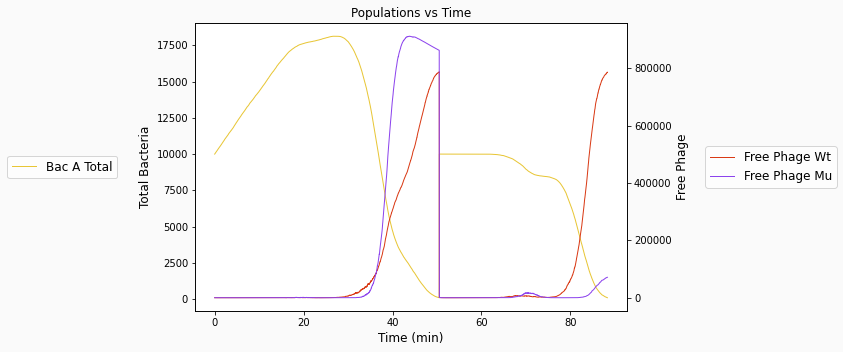

<Figure size 640x480 with 0 Axes>

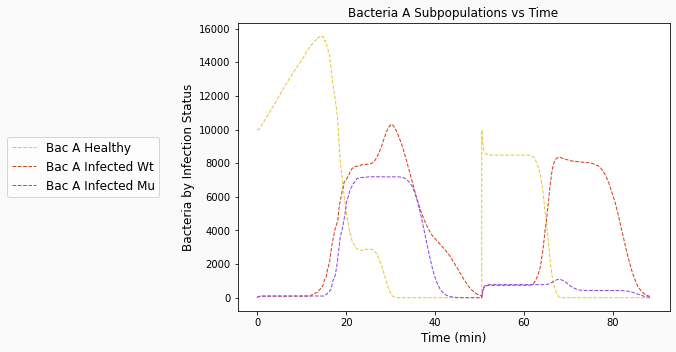

<Figure size 640x480 with 0 Axes>

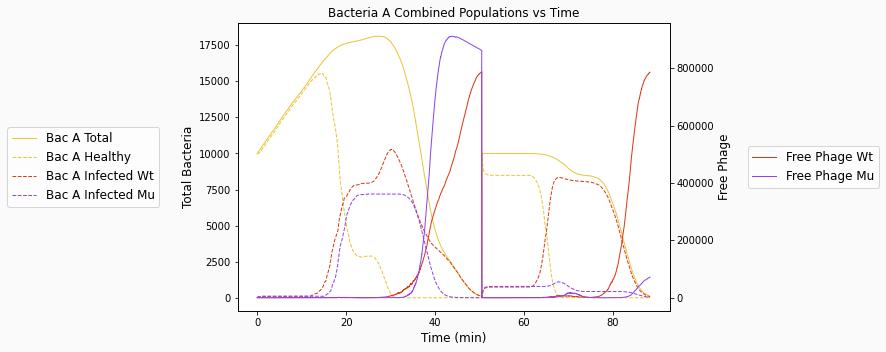

In [62]:
for i in range(len(all_data)):
    print("Analysis: Plotting. Dataset {} of {}.".format(i, len(all_data)))
    data = all_data[i]

    if type(data) == list and i in [0, 1, 2, 3, 4]:  # 1D Reps to flatten and plot
        Plot_0D(data, bacteria_colours, bacteriophage_colours,
        p_low = None, p_high = None, # note, plotting limits are ticks, not times
        legend = True,
        p_totals = False, p_infected = False, p_combined = True, p_PFU = False)
    
    if type(data) != list and i in [0, 1, 2, 3, 4]:  # 0D Reps to plot
        Plot_0D(data, bacteria_colours, bacteriophage_colours,
        p_low = None, p_high = None, # note, plotting limits are ticks, not times
        legend = True,
        p_totals = True, p_infected = True, p_combined = True, p_PFU = False)


#### Wavespeed

If data is 1D, we establish the wavespeed (both with and without treadmill correction)

In [63]:
## Without treadmill correction ##
wavespeeds = [[] for i in range(len(all_data))]
xlows = [[] for i in range(len(all_data))]

for i, data in enumerate(all_data):
    if type(data) == list:
        
        print("Analysis: Wavespeeds. Dataset {} of {}.".format(i, len(all_data)))   
        data = all_data[i]
        wavespeeds[i], xlows[i] = Wavespeed(data, [wcols[0], wcols[1]],
                                  dx = args["dx"], line_function = Z_Line, treadmill = False,
                                  p_low = 0, p_high = -1, plot = True, colour_set = bacteriophage_colours, legend = True)
        

In [64]:
## With treadmill correction ##
for i, data in enumerate(all_data):
    if type(data) == list:
        
        print("Analysis: Wavespeeds. Dataset {} of {}.".format(i, len(all_data)))   
        data = all_data[i]
        wavespeeds[i], xlows[i] = Wavespeed(data, [wcols[0], wcols[1]],
                                  dx = args["dx"], line_function = L_Line, treadmill = True,
                                  p_low = 0, p_high = -1, plot = True, colour_set = bacteriophage_colours, legend = True)

print(wavespeeds)
print(xlows)

[[]]
[[]]


In [65]:
## PHAGE PEAK wavespeed with treadmill correction ##
# This is to get xlow, as a suitable approximation for the onset of steady state
phage_wavespeeds = [[] for i in range(len(all_data))]

for i, data in enumerate(all_data):
    if type(data) == list:
        
        print("Analysis: Wavespeeds. Dataset {} of {}.".format(i, len(all_data)))   
        data = all_data[i]
        phage_wavespeeds[i], xlows[i] = Wavespeed(data, [acols[0], acols[1]],
                                  dx = args["dx"], line_function = L_Line, treadmill = True,
                                  p_low = 0, p_high = -1, plot = True, colour_set = bacteriophage_colours, legend = True)

print(phage_wavespeeds)
print(xlows)

[[]]
[[]]


#### End Times and Winners

In [66]:
end_times = [[] for data in all_data]
winners = [[] for data in all_data]
ratios =  [[] for data in all_data]

for i in range(len(all_data)):
    print("Analysis: End Time. Dataset {} of {}.".format(i, len(all_data)))   
    data = all_data[i]

    # End time by simply reading last row of data frame
    if type(data) == list:
        end_time = data[0].iloc[-1]["Time"]
    else:
        end_time = data.iloc[-1]["Time"]
    end_times[i] = end_time

    try:
        # Winner as simply greater total phage (in deme with highest total phage)
        if type(data) == list:
            peak = Find_Peak(data, [acols[0][0], acols[1][0]])[0][-1]
            peak = int(peak)
            num_0 = data[peak].at[data[peak].shape[0] -1, acols[0][0]]
            num_1 = data[peak].at[data[peak].shape[0] -1, acols[1][0]]
        else:
            num_0 = data.at[data.shape[0] -1, acols[0][0]]
            num_1 = data.at[data.shape[0] -1, acols[1][0]]
    
        if num_1 > num_0:
            winner = acols[1][0][5:]
        else:
            winner = acols[0][0][5:]
    
        winners[i] = winner
        
        # Final Phage Ratio
        if num_1 == 0 or num_0 == 0:
            ratio = 0
        elif num_1 > num_0:
            ratio = num_1/num_0
        else:
            ratio = num_0 / num_1
    
        ratios[i] = ratio
    except:
        print("No winner could be determined. If the experiment used only one strain of phage, this is okay!")

Analysis: End Time. Dataset 0 of 1.


#### Serial Passage Growth Rate

If the experiment was serial passage, we can establish the growth rate by looking at the population of phages just before bottlenecks.

Simulation 0
  times: [ 0.   50.51 88.34]
  phages: [[1.00000e+02 1.00000e+02]
 [7.87622e+05 8.61904e+05]
 [7.85585e+05 7.11610e+04]]



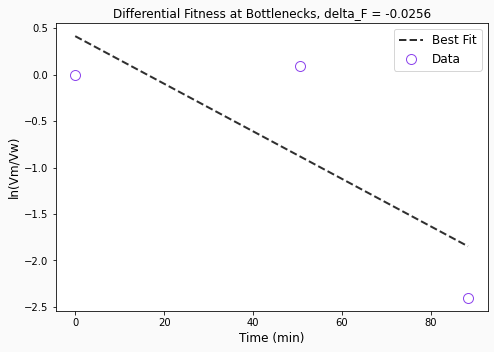

In [67]:
# Calculate differential fitness, delta_F (per minute).
delta_Fs = [[] for data in all_data]
bottlenecks = [[] for data in all_data]

for i, data in enumerate(all_data):
 
    if type(data) != list:

        # Extract Data
        bottleneck_data = data[data["Bottleneck Event?"] == 1.0]
        num_bottlenecks = len(bottleneck_data)
        bottlenecks[i] = num_bottlenecks
        times = np.array(bottleneck_data["Time"])
    
        phages = np.zeros([num_bottlenecks, len(acols)])
        for j, col in enumerate(acols):
            phages[:,j:j+1] = np.array(bottleneck_data[col])

        print("Simulation {}".format(i))
        print("  times:", times)
        print("  phages:", phages)
        print()

        # Calculate fitness
        phage_ratios = []
        log_ratios = []
        for t in range(num_bottlenecks):
            if phages[t,:].all():    # If no phage populations have fallen to zero
                phage_ratios.append(phages[t,1]/phages[t,0])
                log_ratios.append(np.log(phage_ratios[t]))
            else:    # If any phage pool has fallen to zero, stop looking for a fitness difference
                break

        times = times[0:len(log_ratios)]   # If log_ratios is shorter because one pool went to zero, adjust times to be the same length.
        
        if len(log_ratios) > 1:   # If there are at least two points to fit a line to:
            params, covars = sp.optimize.curve_fit(Straight_Line, times, log_ratios)
            
            delta_F = params[0]
            delta_Fs[i] = delta_F

    
            # Plot
            fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])
        
            ax.plot(times, Straight_Line(times, *params), color = charcoal, linestyle = "dashed", label = "Best Fit", linewidth = 2)
            ax.plot(times, log_ratios, marker = "o", linestyle = "none", label = "Data",
                    markersize = 10, markeredgecolor = bacteriophage_colours[1], markerfacecolor = "none") # plot data
        
            ax.set_title("Differential Fitness at Bottlenecks, delta_F = {}".format(np.round(params[0], 4)), fontsize = 12)
            ax.set_xlabel("Time (min)", fontsize = 12)
            ax.set_ylabel("ln(Vm/Vw)", fontsize = 12)
            ax.legend(fontsize = 12)

        else:
            print("Delta F could not be determined because one phage pool hit zero at or before the first true bottleneck event")
    

C:\Users\aaron\AppData\Local\Temp\ipykernel_10948\603984623.py:15: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  CIs[:,j:j+1] = np.reshape(np.array(bottleneck_data[col[0]+" Cumulative"]), newshape = (-1,1))


Simulation 0
  times: [ 0.   50.51 88.34]
  cumulative infections: [[    0.     0.]
 [11272.  7295.]
 [20068.  8505.]]

Infections per bottleneck:
[[    0.     0.]
 [11272.  7295.]
 [ 8796.  1210.]]


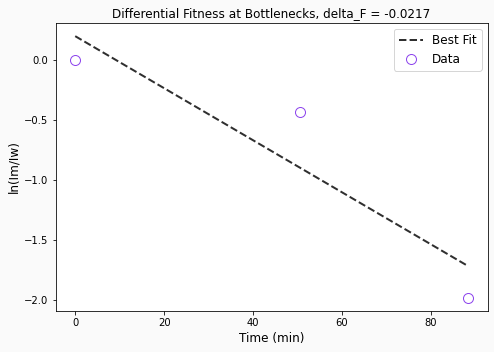

In [68]:
# Calculate differential fitness, delta_F (per minute) FROM CUMULATIVE INFECTION COUNT.
delta_Fs_CI = [[] for data in all_data]

for i, data in enumerate(all_data):
 
    if type(data) != list:

        # Extract Data
        bottleneck_data = data[data["Bottleneck Event?"] == 1.0]
        num_bottlenecks = len(bottleneck_data)
        times = np.array(bottleneck_data["Time"])
    
        CIs = np.zeros([num_bottlenecks, len(acols)])
        for j, col in enumerate(wcols):
            CIs[:,j:j+1] = np.reshape(np.array(bottleneck_data[col[0]+" Cumulative"]), newshape = (-1,1))

        print("Simulation {}".format(i))
        print("  times:", times)
        print("  cumulative infections:", CIs)
        print()

        # This is currently cumulative across all time, we actually want cumulative across only the current bottleneck
        for r in reversed(range(1, np.shape(CIs)[0])):
            CIs[r, :] -= CIs[r-1, :]

        print("Infections per bottleneck:")
        print(CIs)

        # Calculate fitness
        CI_ratios = []
        log_ratios = []
        for t in range(num_bottlenecks):
            if t == 0:
                CI_ratios.append(1)
                log_ratios.append(0)
            elif CIs[t,:].all():    # If no phage populations have fallen to zero
                CI_ratios.append(CIs[t,1]/CIs[t,0])
                log_ratios.append(np.log(CI_ratios[t]))
            else:    # If any phage pool has fallen to zero, stop looking for a fitness difference
                break

        times = times[0:len(log_ratios)]   # If log_ratios is shorter because one pool went to zero, adjust times to be the same length.
        
        if len(log_ratios) > 1:
            params, covars = sp.optimize.curve_fit(Straight_Line, times, log_ratios)
            
            delta_F = params[0]
            delta_Fs_CI[i] = delta_F
    
        
            # Plot
            fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
            ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])
        
            ax.plot(times, Straight_Line(times, *params), color = charcoal, linestyle = "dashed", label = "Best Fit", linewidth = 2)
            ax.plot(times, log_ratios, marker = "o", linestyle = "none", label = "Data",
                    markersize = 10, markeredgecolor = bacteriophage_colours[1], markerfacecolor = "none") # plot data
        
            ax.set_title("Differential Fitness at Bottlenecks, delta_F = {}".format(np.round(params[0], 4)), fontsize = 12)
            ax.set_xlabel("Time (min)", fontsize = 12)
            ax.set_ylabel("ln(Im/Iw)", fontsize = 12)
            ax.legend(fontsize = 12)

        else:
            print("Delta F could not be determined because one phage pool achieved no infections at any time")
    

#### Growth rate from infected cells

If the experiment was one dimensional, we can extract the growth rate from the ratio of infected cells, according to

$$\Delta F = \frac{d}{dt}\biggl(\ln\bigl(\frac{I_2}{I_1}\bigr)\biggr) $$

In [69]:
if type(all_data[0]) == list:

    # First flatten data over space. Plot_0D already does this!
    
    flattened_data = []
    
    for i, data in enumerate(all_data):
        if type(data) == list:
            flattened_data_i = Plot_0D(data, bacteria_colours, bacteriophage_colours, p_low = None, p_high = None,
                                       legend = True, p_totals = False, p_infected = False, p_combined = False, p_PFU = False)
            flattened_data.append(flattened_data_i)

In [70]:
if type(all_data[0]) == list:
    
    fig = plt.figure(figsize=(12,6), dpi = 72, facecolor = off_white)
    ax = fig.add_axes([0.25, 0.167, 0.5, 0.666])
    ay = ax.twinx()   
    
    for i, data in enumerate(flattened_data):
    
        winner = winners[i]
        winner_index = acols.index(["Free "+winner])
        start_time = xlows[i][winner_index]            # Even though based on I, use start of V travelling wave to determine start time
        start_tick = int(start_time / args["dt"] + 1) 
        print(start_time)
        print(start_tick)
    
        # plot the numbers of infected cells
        ax.plot(data["Time"][start_tick:-1], data[wcols[0]][start_tick:-1], color = bacteriophage_colours[0], marker = "none", linestyle = "solid",
                label = wcols[0], linewidth = 1)
        ax.plot(data["Time"][start_tick:-1], data[wcols[1]][start_tick:-1], color = bacteriophage_colours[1], marker = "none", linestyle = "solid",
                label = wcols[1], linewidth = 1)
    
        # calculate the ratio, discarding inf or zero values.
        print(np.array(data[wcols[1]][start_tick:-1]).flatten()) #### debugging ####
        print(np.array(data[wcols[0]][start_tick:-1]).flatten()) #### debugging ####
        ratio = np.array(data[wcols[1]][start_tick:-1]).flatten() / np.array(data[wcols[0]][start_tick:-1]).flatten()
        time = np.array(data["Time"][start_tick:-1]).flatten()
    
        ratio, time = list(ratio), list(time)
        for j in reversed(range(len(ratio))):
            if ratio[j] == 0 or ratio[j] == np.inf:
                del ratio[j]
                del time[j]
        ratio, time = np.array(ratio), np.array(time)
    
        # plot the log of the ratio    
        log_ratio = np.log(ratio)
        print("Are there any NaNs in log_ratio? {}!".format(np.isnan(log_ratio).any()))
            
        ay.plot(time, log_ratio, color = bacteriophage_colours[2], marker = "none", linestyle = "solid",
                label = "ln(I2/I1)", linewidth = 1)
    
        # fit a straight line
        try:
            params, covars = sp.optimize.curve_fit(Straight_Line, time, log_ratio)
            ay.plot(time, Straight_Line(time, *params), color = bacteriophage_colours[2], marker = "none", linestyle = "dashed", linewidth = 1)
            delta_Fs[i] = params[0]    # set Delta_F to line gradient
            print(params)
        except:
            print("""Line fitting failed. The only known cause is that one phage strain has been eliminated before
                  the onset of travelling wave behaviour""")
        
        ax.set_xlabel("Time (min)", fontsize = 12)
        ax.set_ylabel("Infected Bacteria", fontsize = 12)
        ay.set_ylabel("ln(I2/I1)", fontsize = 12)
        ax.set_title("Infected Bacteria vs Time", fontsize = 12)




## 13b. Obsolete Analysis
Analytical methods in this section are retained for possible future utility, but are judge not to be insightful at this time

#### Call Steady State

In [71]:
# steady_states = [[] for i in range(len(all_data))]


# for i in range(len(all_data)):
#     print("Analysis: Steady State. Dataset {} of {}.".format(i, len(all_data)))   
#     data = all_data[i]
#     steady_states[i] = Call_Steady_State(data, ss_cols)


#### Abundance Statistics and Winners

In [72]:
# finabs = np.zeros(len(all_data))
# abdirs = np.zeros(len(all_data))
# winners = [[] for i in range(len(all_data))]

# for i in range(len(all_data)):
#     print("Analysis: Abundance. Dataset {} of {}.".format(i, len(all_data)))   
#     data = all_data[i]

#     # Final abundance
#     finabs[i] = Abundance(data, acols[0], acols[1])[-1]

#     # Abundace plots and derivative
#     abdirs[i] = Abundance_Stats(data, acols[0], acols[1], window = 1001, p_low = steady_states[i][0], p_high = -1)

#     # Winner
#     if finabs[i] > 0:
#         winners[i] = acols[0]
#     elif finabs[i] < 0:
#         winners[i] = acols[1]

#### Old Histogram-Based Growth Rate Prediction

(Also Fisher wave velocity)

In [73]:
# def Histogram(dist, mean, std, lower_bound, alpha,
#               sample_size = 256_000, number_of_bins = 256, global_min = 0, global_max = 60):  # Returns p(tau) given a distribution

#     # Calculate bin width and initialise
#     bin_width = (global_max - global_min) / number_of_bins
#     rescale = 1 / (bin_width*sample_size)
#     sample = np.zeros(sample_size)

#     # Draw samples
#     for j in range(0, sample_size):
#         sample[j] = dist(mean, std, lower_bound, alpha)

#     # Create histogram
#     counts, bins = np.histogram(sample, bins = number_of_bins, range = (global_min, global_max))    # Then plot a histogram
#     probs = counts*rescale

#     # Numpy "bins" are the fenceposts, whereas we want the centers of the fields:
#     bin_gap = bins[1] - bins[0]
#     centers = copy.copy(bins[1:])
#     centers[:] -= 0.5*bin_gap
    
#     return(probs, centers)

In [74]:
# def Predict_Growth_Rate_Old(Phage_Pop, sample_size = 256_000, number_of_bins = 256, global_min = 0, global_max = 60,
#                         ads_correction = False, ads_b0 = 1):

#     # First, create the "tau axis" and p(tau) by calling Histogram:
#     p_tau, tau = Histogram(Phage_Pop.tau_distribution, Phage_Pop.lysis_time_mean,
#                            Phage_Pop.lysis_time_std, Phage_Pop.lysis_time_lower_bound,
#                            Phage_Pop.lysis_time_alpha,
#                            sample_size, number_of_bins, global_min, global_max)

#     # If we are correcting for adsorption time, calculate the correction
#     if ads_correction:
#         ads_time = 1 / (Phage_Pop.adsorption_rate * ads_b0)   # Characteristic adsorption time, 1/aB0.
#         print("Running adsorption correction, characteristic adsorption time {} mins.".format(ads_time))
#     else:
#         ads_time = 0
#         ads_time_bins = 0
#         print("Predicting growth rate without adsorption correction")
    
#     # Now create tau axis including ads time. If ads correction not applied, simply reproduce tau axis
#     tau_ads = copy.copy(tau)
#     tau_ads[:] = tau[:] + ads_time

#     # Create beta(tau) by calling the phage's burst function (this one is based on tau WITHOUT adsorption):
#     beta_tau = np.zeros(len(tau))
#     ln_beta_tau = np.zeros(len(tau))
#     for i in range(len(tau)):
#         beta_tau[i] = Phage_Pop.burst_function(tau[i], Phage_Pop.maturation_rate, Phage_Pop.eclipse_period,
#                                                        Phage_Pop.burst_size_mean, Phage_Pop.burst_size_std,
#                                                        Phage_Pop.burst_size_lower_bound)
#         if beta_tau[i] > 0:
#             ln_beta_tau[i] = np.log(beta_tau[i])

#     # Create freq = 1/tau_ads
#     freq = 1/tau_ads
    
#     # Create the full integrand
#     integrand = ln_beta_tau * p_tau * freq

#     # Numerical integration
#     d_tau = tau[1] - tau[0]
#     integral = 0
#     for i in range(len(tau)):
#         integral += integrand[i]*d_tau

#     # Finally, predict the Fisher Velocity
#     v = 2 * (integral * Phage_Pop.diffusion_rate)**0.5

#     return(integral, v)

## 14. Save Data

Data saved in a format compataible with planned ```Stochastic 3 Heatmap.py```. 
Current naming convention is ```sim {name} {Nr} {T} {arg x1} {arg y1} {arg x2} {arg y2}```

File is csv, one row per rep. Columns are:  
[0] - Time  
[1] - Winner  
[2] - Final Ratio  
[3] - Wavespeed (for Treadmill)  
[4] - Number of Bottlenecks (for Serial Passage)  
[5] - delta_F (for Serial Passage or Treadmill)  
[6] - delta_F_CI (for Serial Passage)  
[7] - Predicted Growth Rates (not including asorption)  
[8] - Predicted Growth Rates (including asorption)  

I.e. we do not save the whole DF for every sim, only the aggregate trends.

In [75]:
predictions_no_ads = [[prediction_1, prediction_2] for r in range(Nr)]
predictions_ads = [[prediction_1a, prediction_2a] for r in range(Nr)]

# Check everything looks sensible
print(end_times)
print(winners)
print(ratios)
print(wavespeeds)
print(bottlenecks)
print(delta_Fs)
print(predictions_no_ads)
print(predictions_ads)

[np.float64(88.34)]
['Phage Wt']
[np.float64(11.03954413231967)]
[[]]
[3]
[np.float64(-0.025610393406835706)]
[[np.float64(0.2930880095024111), np.float64(0.27652343539715996)]]
[[np.float64(0.28708833805929623), np.float64(0.27206276589913314)]]


In [76]:
# Some items are strings, so whole thing must be converted to csv via pandas
data_to_save = pd.DataFrame({"winners" : winners,
                             "end times" : end_times,
                             "ratios" : ratios,
                             "wavespeeds" : wavespeeds,
                             "bottlenecks" : bottlenecks,
                             "delta_Fs" : delta_Fs,
                             "delta_Fs_CI" : delta_Fs_CI,
                             "growth rates (no ads)" : predictions_no_ads,
                             "growth rates (ads)" : predictions_ads})

data_to_save

,winners,end times,ratios,wavespeeds,bottlenecks,delta_Fs,delta_Fs_CI,growth rates (no ads),growth rates (ads)
0,Phage Wt,88.34,11.039544,[],3,-0.02561,-0.021703,"[0.2930880095024111, 0.27652343539715996]","[0.28708833805929623, 0.27206276589913314]"


In [77]:
# Save
data_to_save.to_csv("Sim_{}_{}_{}_{}_{}_{}_{}".format(name, Nr, args["T"], x1, y1, x2, y2))

In [78]:
# Save each DF as its own file (currently only if sim is 0D)

save_all = True

if save_all and type(all_data[0]) != list:
    for i in range(len(all_data)):
        all_data[i].to_csv("Data_{}_{}_{}_{}_{}_{}_{}".format(name, i, args["T"], x1, y1, x2, y2))

## Testing

#### Still to do
- logistic beta